### Imports e Configurações

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import yfinance as yf

from datetime import datetime, timedelta, timezone

from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, MinMaxScaler

from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import kstest_normal,het_arch, acorr_ljungbox
from statsmodels.tsa.stattools import acf, q_stat, adfuller, kpss
from statsmodels.api import qqplot
from scipy.stats import probplot, moment, shapiro, jarque_bera

import pmdarima as pm

In [5]:
seed = 2022 

In [6]:
pd.set_option('display.max_colwidth', None)

In [7]:
img_dir = os.path.join('..', 'img')

### Funções Uteis

In [8]:
# Calcular a volatilidade realizada diaria
def realized_volatility_daily(series_log_return):
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))
    # return np.sqrt(np.sum(series_log_return**2))
# Calcular a volatilidade realizada diaria
def realized_volatility(series_log_return):
    n = len(series_log_return)
    # return np.sqrt(np.sum(series_log_return**2)/(n - 1))
    return np.sqrt(np.sum(series_log_return**2))

def transform_volatility_to_scaler(scaler, tf_series):
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output


In [9]:
def RMSPE(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def MSE(y_true, y_pred):
    return mse(y_true, y_pred)

def RMSE(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))  
     
def MAPE(y_true, y_pred): 
    return mean_absolute_percentage_error(y_true, y_pred) 

In [10]:
def get_resid_garch(model):
    return model.std_resid
    # gm_resid = model.resid
    # gm_std = model.conditional_volatility
    # return gm_resid / gm_std

def pvalue_ljungbox(values):
    return acorr_ljungbox(values, lags=[10]).lb_pvalue.iloc[0]

def pvalue_het_arch(values):
    return het_arch(values)[1]

def pvalue_shapiro(values):
    return shapiro(values)[1]

In [11]:
perf_df = pd.DataFrame(columns=['Validation MSE', 'Validation RMSPE', 'Validation RMSE', "MAPE"])
analysis_df = pd.DataFrame(columns=['AIC', 'BIC', 'LB', 'LB(r²)', 'ARCH', 'SW'])

def log_perf(y_true, y_pred, model_name):
    perf_df.loc[model_name] = [
        MSE(y_true, y_pred),
        RMSPE(y_true, y_pred), 
        RMSE(y_true, y_pred), 
        MAPE(y_true, y_pred)
    ]
    return perf_df

def log_garch(model, model_name, isNormal = True):
    analysis_df.loc[model_name] = [
        model.aic,
        model.bic,
        pvalue_ljungbox(get_resid_garch(model)),
        pvalue_ljungbox(get_resid_garch(model)**2),
        pvalue_het_arch(get_resid_garch(model)),
        pvalue_shapiro(get_resid_garch(model)) if isNormal else np.nan
    ]
    return analysis_df

def reset_log_garch():
    analysis_df = pd.DataFrame(columns=[ 'AIC', 'BIC', 'LB', 'LB(r²)', 'ARCH', 'SW'])

    
def reset_log_perf():
    perf_df = pd.DataFrame(columns=['Validation MSE', 'Validation RMSPE', 'Validation RMSE', "MAPE"])

In [12]:
def correlogram(x, lags, title):
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0],grid= True, color='red')
    q_p = np.max(q_stat(acf(x,lags), len(x))[1])
    stats= f'ADF:{adfuller(x)[1]:.2f},\nQ-Stat:{q_p:.2f}'
    axes[0][0].text(x=.03, y=.85,s=stats, transform=axes[0][0].transAxes)
    
    #probability plot 
    probplot(x, plot=axes[0][1])
    mean, variance, skewness, kurtosis = moment(x, moment=[1, 2, 3, 4])
    stats1 = f'Mean: {mean:.2f}\nSD: {np.sqrt(variance):.2f}\nSkew: {skewness:.2f}\nKurtosis:{kurtosis:.2f}'
    axes[0][1].text(x=.02, y=.75,s=stats1, transform=axes[0][1].transAxes)
    
    #ACF and PACF plots
    plot_acf(x, lags=lags, zero=False, ax=axes[1][0],alpha=0.05,)
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [13]:
def viz_model(y_true, y_pred, model_name, save = False):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)
        if(save):
                plt.savefig(os.path.join(img_dir, 'forecasted_volatility_' + model_name + '.png'), 
                        dpi=300, bbox_inches='tight')
        plt.show()

In [14]:
### GARCH FUNTIONS
def scale_tf_cond_vol(model_result):
    cond_vol = model_result.conditional_volatility
    scaler = MinMaxScaler()
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))
    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

def viz_only_cond_vol(cond_vol_series, model_name, save = False):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(cond_vol_series, color='orange', lw=2)
        plt.legend()
        if(save):
                plt.savefig(os.path.join(img_dir, 'cond_volatility_' + model_name + '.png'), 
                        dpi=300, bbox_inches='tight')
        plt.show();


### Analise Exploratória 

In [245]:
start = datetime(2018, 1, 1)
end = datetime(2023, 2, 1)
start_covid = datetime(2020,2,20)
end_covid = datetime(2021, 2, 28)

In [16]:
ticker_name = "^BVSP"
ticker = yf.Ticker(ticker_name)
df = ticker.history(start=start, 
                    end=end, 
                    interval="1d",
                    )

In [17]:
## Interpolar Time series (Preencher valores nulos)
date_range = pd.date_range(
    start=start, 
    end=end,
    freq='D'
  )
data = df.reset_index()
data['Date'] = data['Date'].astype('datetime64[ns]')
# data_aux = pd.DataFrame({'Date': date_range })
# data = pd.merge(data_aux, data, on='Date', how='left')
# data = data.set_index(["Date"], drop=True)  
# data.interpolate(method='linear', inplace=True)
# data = df.reset_index()
data['Date'] =data['Date'].apply(lambda x: x.replace(tzinfo=None))
# data_aux = pd.DataFrame({'Date': date_range })
# data = pd.merge(data_aux, data, on='Date', how='left')
data = data.set_index(["Date"], drop=True)  
# data.interpolate(method='linear', inplace=True)


In [18]:
data = data.dropna()

In [19]:
df = data

In [20]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-02 02:00:00,76403.0,77909.0,76403.0,77891.0,2880300,0.0,0.0
2018-01-03 02:00:00,77889.0,78414.0,77602.0,77995.0,3142200,0.0,0.0
2018-01-04 02:00:00,77998.0,79135.0,77998.0,78647.0,3486100,0.0,0.0
2018-01-05 02:00:00,78644.0,79071.0,78218.0,79071.0,2747100,0.0,0.0
2018-01-08 02:00:00,79070.0,79395.0,78631.0,79379.0,2550800,0.0,0.0
...,...,...,...,...,...,...,...
2023-01-25 03:00:00,113028.0,114386.0,111927.0,114195.0,11413000,0.0,0.0
2023-01-26 03:00:00,114271.0,114835.0,113591.0,114109.0,10920800,0.0,0.0
2023-01-27 03:00:00,114178.0,114191.0,112044.0,112502.0,10614500,0.0,0.0


Inserir Variavies Dummy

In [246]:
df['covid'] = df.index.map(lambda date : 0 if date > start_covid and date < end_covid else 1)

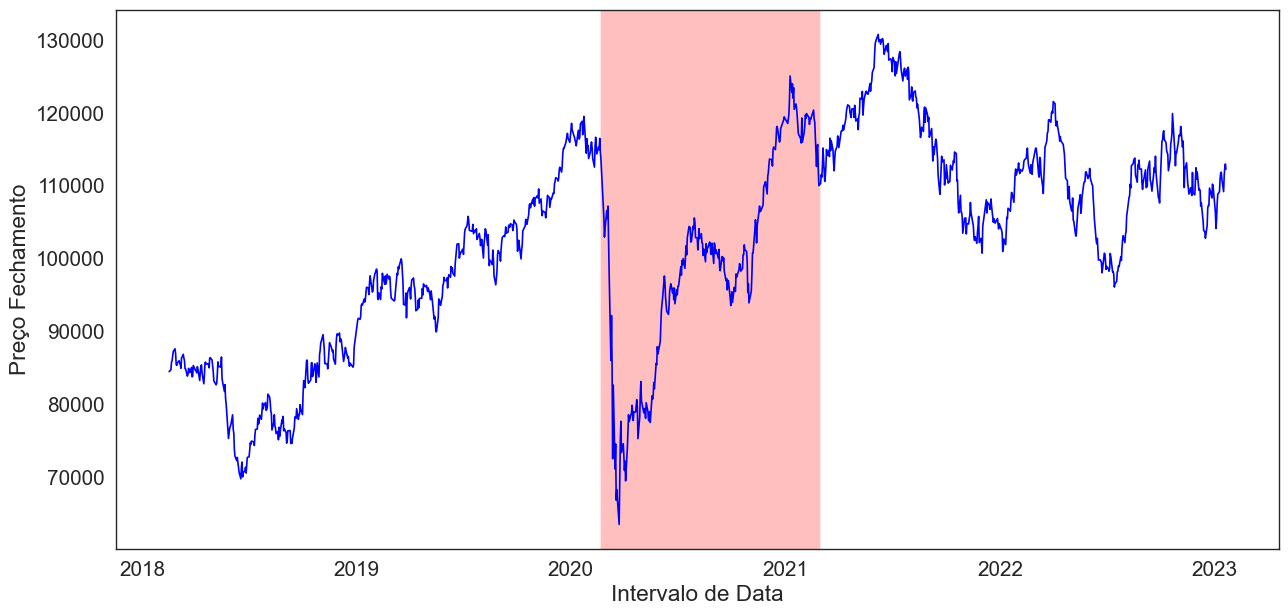

In [247]:
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(15,7))
    ax1.plot(df.Close, color='blue', label='Preço Fechamento')  
    plt.xlabel('Intervalo de Data')
    plt.ylabel('Preço Fechamento')
    ax1.axvspan(start_covid,end_covid, facecolor='red', alpha=0.25)
    plt.show()


In [23]:
df['returns'] = 100 * df['Close'].pct_change().dropna()

LOG RETURNS FORMULA:

$r_{t, t+i} = log(P_{t+i} / P_{t})$

In [24]:
df['log_returns'] = np.log(df['Close']/df['Close'].shift(1))

In [25]:
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,covid,returns,log_returns
Date,,,,,,,,,,
2018-01-02 02:00:00,76403.0,77909.0,76403.0,77891.0,2880300,0.0,0.0,0,NaN,NaN
2018-01-03 02:00:00,77889.0,78414.0,77602.0,77995.0,3142200,0.0,0.0,0,0.133520,0.001334
2018-01-04 02:00:00,77998.0,79135.0,77998.0,78647.0,3486100,0.0,0.0,0,0.835951,0.008325


In [26]:
df.dropna(inplace=True)

In [27]:
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,covid,returns,log_returns
Date,,,,,,,,,,
2018-01-03 02:00:00,77889.0,78414.0,77602.0,77995.0,3142200,0.0,0.0,0,0.133520,0.001334
2018-01-04 02:00:00,77998.0,79135.0,77998.0,78647.0,3486100,0.0,0.0,0,0.835951,0.008325
2018-01-05 02:00:00,78644.0,79071.0,78218.0,79071.0,2747100,0.0,0.0,0,0.539118,0.005377


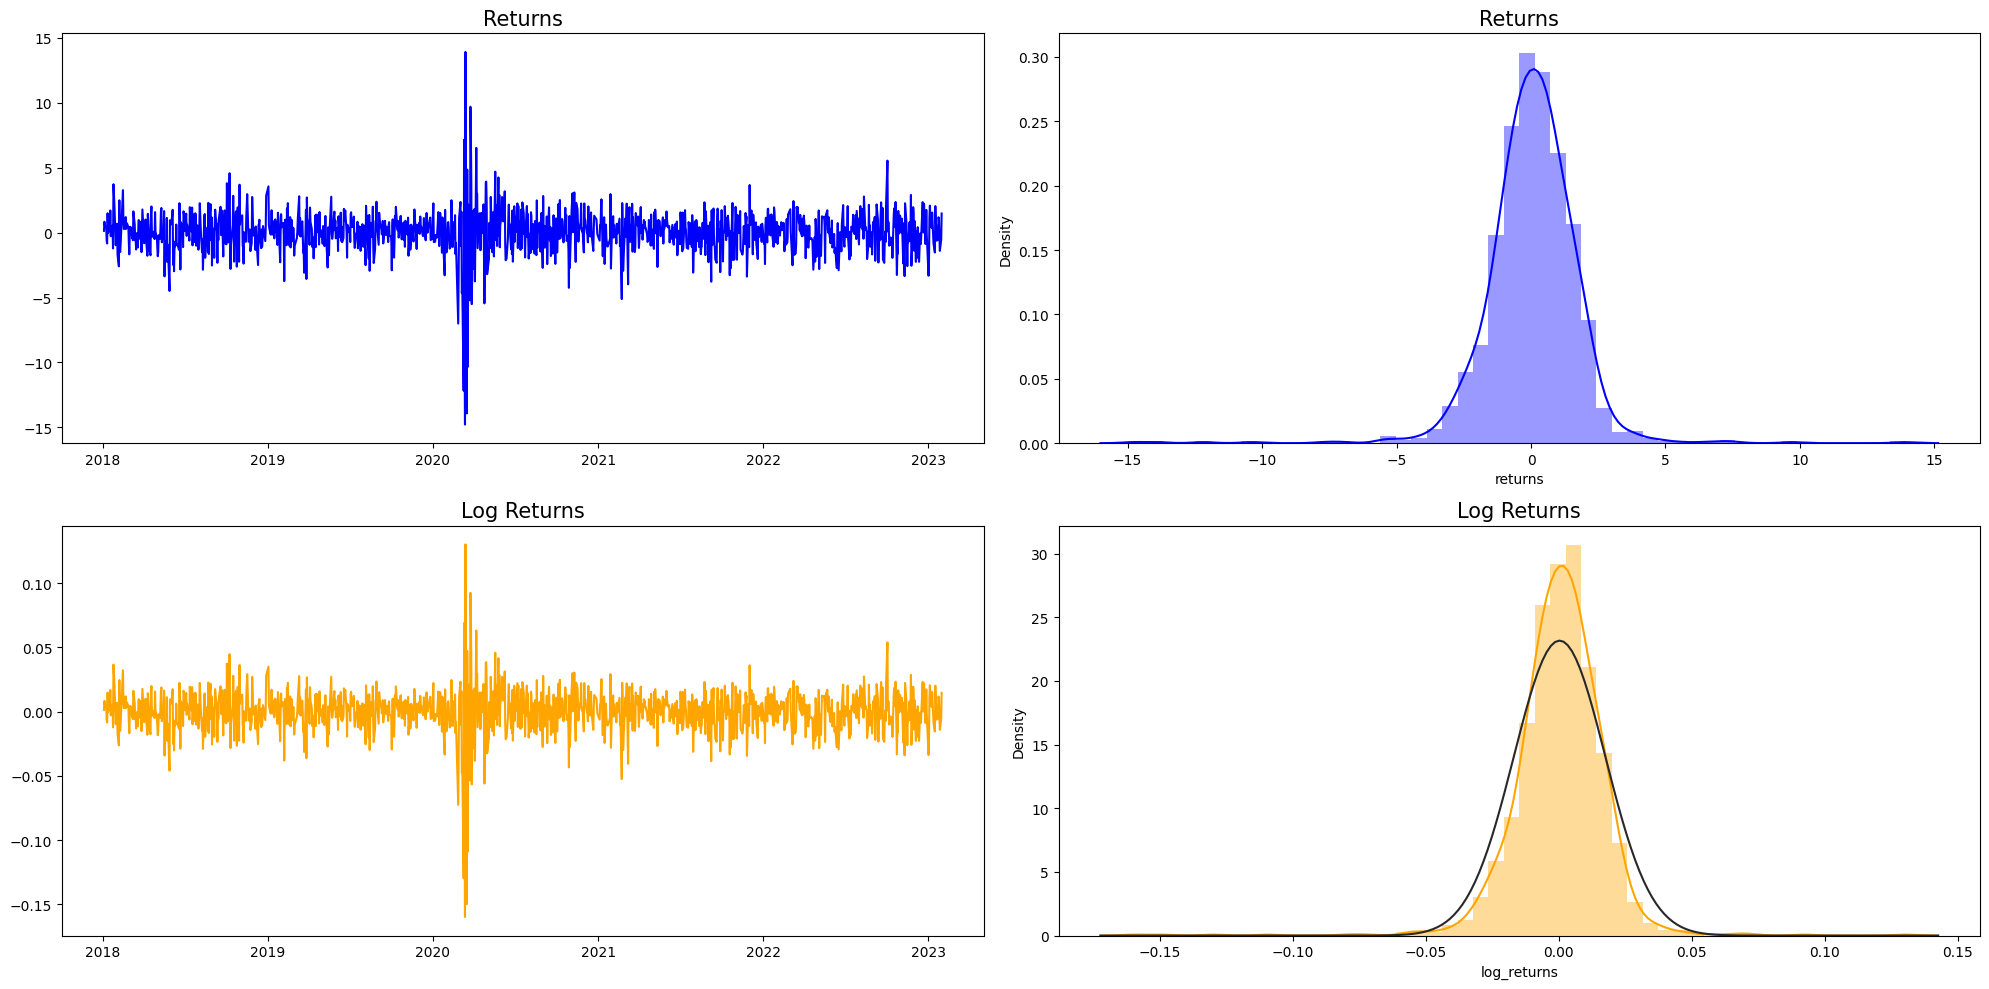

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

axes[0][0].plot(df['returns'], color='blue')
axes[0][0].set_title('Returns', fontsize=15)

sns.distplot(df['returns'],  color='blue',
             bins=50, ax=axes[0][1])
axes[0][1].set_title('Returns', fontsize=15)

axes[1][0].plot(df['log_returns'], color='orange')
axes[1][0].set_title('Log Returns', fontsize=15)

sns.distplot(df['log_returns'], norm_hist=True, fit=stats.norm, color='orange',
             bins=50, ax=axes[1][1])
axes[1][1].set_title('Log Returns', fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'returns.jpg'), dpi=300, bbox_inches='tight')
fig.show();

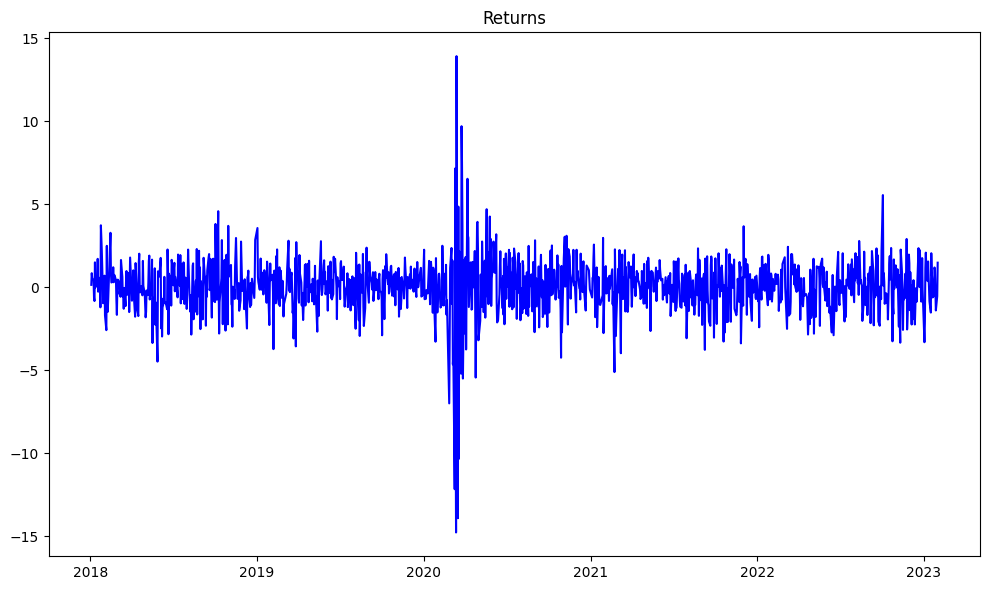

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(df['returns'], color='blue')
plt.title('Returns')
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'simple-return.png'), dpi=300, bbox_inches='tight')
fig.show();

In [30]:
df['returns'].describe()

count    1259.000000
mean        0.044648
std         1.705459
min       -14.779679
25%        -0.790934
50%         0.062529
75%         0.968740
max        13.908215
Name: returns, dtype: float64

In [31]:
stats.skew(df['returns'])

-0.9174751095867717

In [32]:
stats.kurtosis(df['returns'])

15.61738008523476

In [33]:
df['log_returns'].describe()

count    1259.000000
mean        0.000299
std         0.017224
min        -0.159930
25%        -0.007941
50%         0.000625
75%         0.009641
max         0.130223
Name: log_returns, dtype: float64

In [34]:
stats.skew(df['log_returns'])

-1.3638726564411485

In [35]:
stats.kurtosis(df['log_returns'])


17.61083887504471

In [36]:
shapiro(df['returns'])

ShapiroResult(statistic=0.8738958239555359, pvalue=1.0187226189141378e-30)

#### **Returns/Log Returns Estacionariedade**

In [37]:
adfuller_results = adfuller(df['log_returns'])

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -12.003856416927121
p-value: 3.298626469473426e-22
Critical Values:
1%: -3.4356
5%: -2.8639
10%: -2.5680


In [38]:
# RETURNS
adfuller_results = adfuller(df['returns'])

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -11.168826061892032
p-value: 2.6720930809323246e-20
Critical Values:
1%: -3.4356
5%: -2.8639
10%: -2.5680


In [39]:
kpss_results = kpss(df['returns']);
print(kpss_results)

(0.051954162050138857, 0.1, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\gabriel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Para o nível de significancia com alpha igual a 0.05, o `p-value` de ambos, tanto o Retorno quanto do Log Retorno são menores que o alpha, logo tem-se evidencia suficiente para rejeitar a Hipotese nula.

### Verificar Autocorrelação e Autocorrelação Parcial

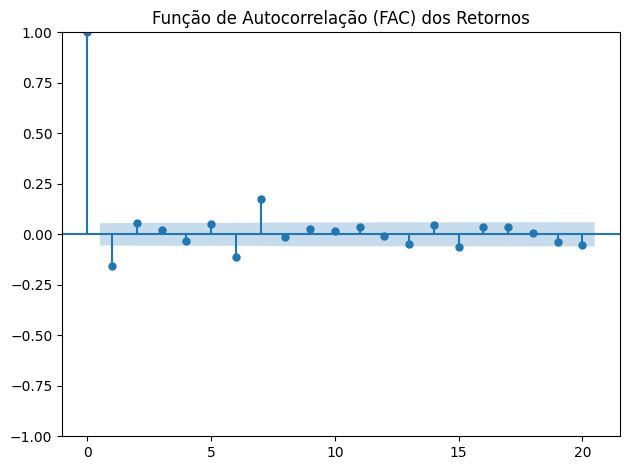

In [40]:
plot_acf(df['returns'], lags=20,  title="Função de Autocorrelação (FAC) dos Retornos");
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'fac-return.jpg'), dpi=300, bbox_inches='tight')

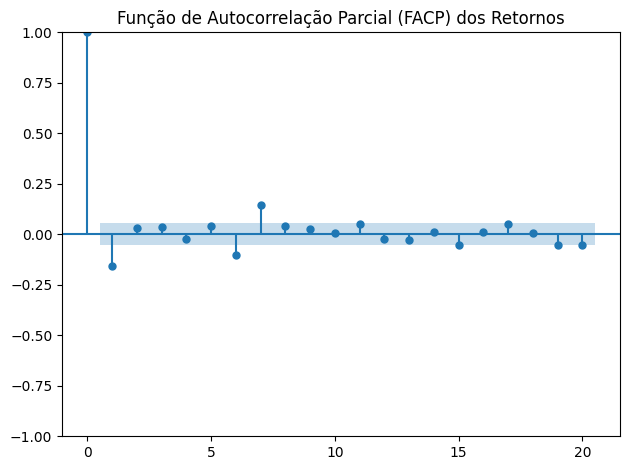

In [41]:
plot_pacf(df['returns'], lags=20, title="Função de Autocorrelação Parcial (FACP) dos Retornos");
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'facp-return.jpg'), dpi=300, bbox_inches='tight')

In [42]:
acorr_ljungbox(df['returns'], lags=10)

,lb_stat,lb_pvalue
1,31.177437,2.354873e-08
2,35.153454,2.325544e-08
3,35.786854,8.307088e-08
4,36.988685,1.810997e-07
5,40.029609,1.472977e-07
6,56.630470,2.170259e-10
7,94.510279,1.462138e-17
8,94.673179,5.214613e-17
9,95.719431,1.151557e-16
10,96.013740,3.410450e-16


### Volatiliade Realizada

In [43]:
INTERVAL_WINDOW = 30
n_future = 7

df['vol_current'] = df['log_returns'].rolling(window=INTERVAL_WINDOW)\
  .apply(realized_volatility_daily)

df['vol_future'] = df['log_returns']\
    .shift(-n_future)\
    .rolling(window=INTERVAL_WINDOW)\
      .apply(realized_volatility_daily)


In [44]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,covid,returns,log_returns,vol_current,vol_future
Date,,,,,,,,,,,,
2018-01-03 02:00:00,77889.0,78414.0,77602.0,77995.0,3142200,0.0,0.0,0,0.133520,0.001334,NaN,NaN
2018-01-04 02:00:00,77998.0,79135.0,77998.0,78647.0,3486100,0.0,0.0,0,0.835951,0.008325,NaN,NaN
2018-01-05 02:00:00,78644.0,79071.0,78218.0,79071.0,2747100,0.0,0.0,0,0.539118,0.005377,NaN,NaN
2018-01-08 02:00:00,79070.0,79395.0,78631.0,79379.0,2550800,0.0,0.0,0,0.389523,0.003888,NaN,NaN
2018-01-09 02:00:00,79379.0,79415.0,78699.0,78864.0,3458600,0.0,0.0,0,-0.648786,-0.006509,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25 03:00:00,113028.0,114386.0,111927.0,114195.0,11413000,0.0,0.0,0,1.032488,0.010272,0.013759,NaN
2023-01-26 03:00:00,114271.0,114835.0,113591.0,114109.0,10920800,0.0,0.0,0,-0.075310,-0.000753,0.013759,NaN
2023-01-27 03:00:00,114178.0,114191.0,112044.0,112502.0,10614500,0.0,0.0,0,-1.408303,-0.014183,0.014008,NaN


In [45]:
df.dropna(inplace=True)

Text(0, 0.5, 'Preço Fechamento')

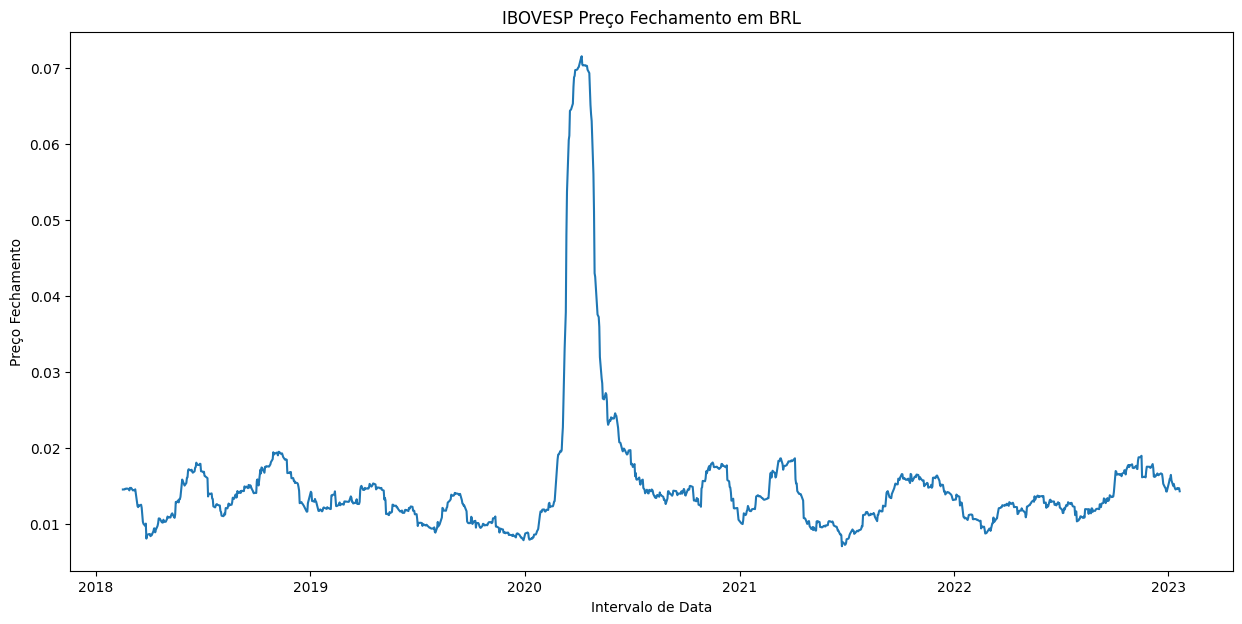

In [46]:
plt.figure(figsize=(15,7))
plt.title('IBOVESP Preço Fechamento em BRL')
plt.plot(df['vol_current'])
plt.xlabel('Intervalo de Data')
plt.ylabel('Preço Fechamento')

### Treino - Teste - Validação 

O dataset será dividido em:
- Os 30 itens finais serão utilizados para teste final.
- 1 ano inteiro para validação e ajustes do modelo
- E o restante para treinamento

In [47]:
test_size = 30
val_size = 365

# INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# PARA DIVIDIR O DATASET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [48]:
print(f'Training \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'Validation \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'Test \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

Training 	From: 2018-02-16 02:00:00 	to: 2021-06-23 03:00:00 	828 days
Validation 	From: 2021-06-24 03:00:00 	to: 2022-12-08 03:00:00 	365 days
Test 		From: 2022-12-09 03:00:00 	to: 2023-01-20 03:00:00 	30 days


In [49]:
y_train = df['vol_future'][train_idx]
y_val = df['vol_future'][val_idx]
y_test = df['vol_future'][test_idx]

In [50]:
x_train = df['vol_current'][train_idx]
x_val = df['vol_current'][val_idx]
x_test = df['vol_current'][test_idx]

In [51]:
r_train = df['returns'][train_idx]
r_val = df['returns'][val_idx]
r_test = df['returns'][test_idx]

In [52]:
lr_train = df['log_returns'][train_idx]
lr_val = df['log_returns'][val_idx]
lr_test = df['log_returns'][test_idx]

In [216]:
covid_train = df['covid'][train_idx]
covid_val = df['covid'][val_idx]

### Normalizar os dados

In [54]:
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT REALIZED VOLATILITY IN TRAINING
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [55]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

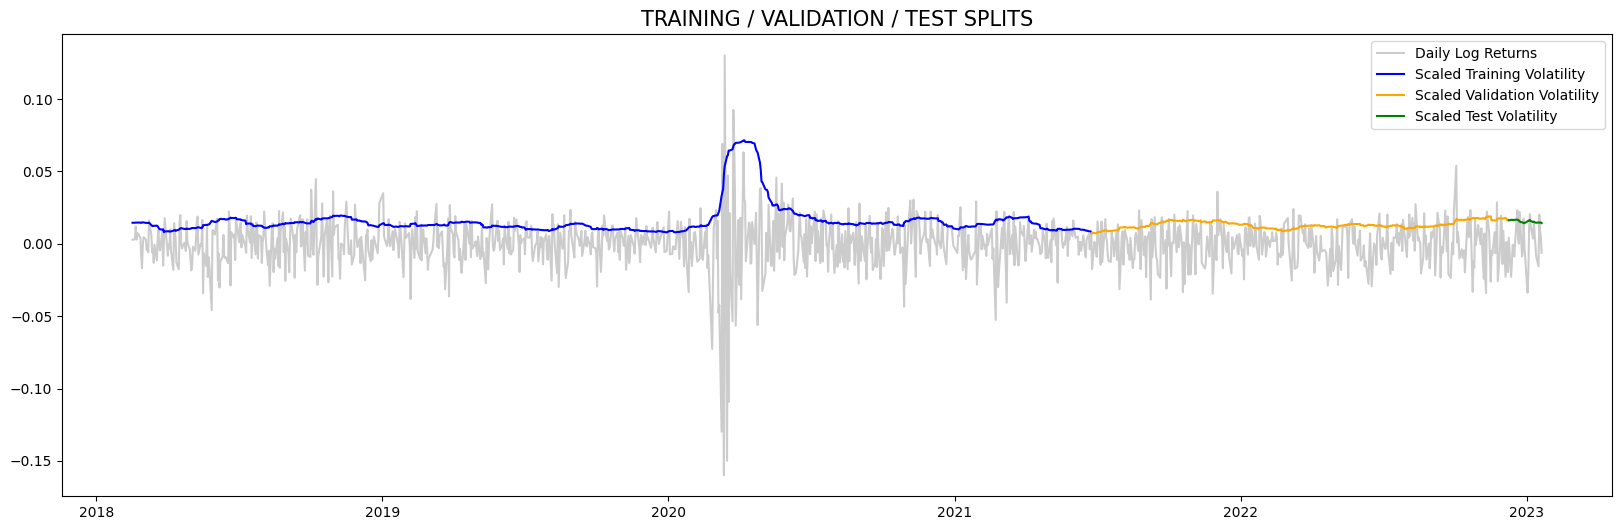

In [56]:
plt.figure(figsize=(20,6))

plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

plt.plot(x_train, color='blue', label='Scaled Training Volatility')
plt.plot(x_val, color='orange', label='Scaled Validation Volatility')
plt.plot(x_test, color='green', label='Scaled Test Volatility')

plt.plot()
plt.title(f'TRAINING / VALIDATION / TEST SPLITS', 
          fontsize=15)
plt.legend(frameon=True)
plt.savefig(os.path.join(img_dir, 'train_val_test.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [239]:
def expading_window_forecast_garch(arch_model, use_covid = False):
    size = len(val_idx)
    rolling_forecasts = []
    idx = df.index
    # Set de validação
    for i in range(0, size, 1):
    # Pegar os valores anteriores a esse step
        idx = val_idx[i]
        train = df.returns[:idx]
        covid = df.covid[:idx]
        # treinar o modelo até esse step
        model = arch_model(train, covid)
        model_fit = model.fit(disp='off')
        # fazer a predição com n_future 
        if use_covid:
            values = model_fit.forecast(horizon=1, x=[df.covid[idx]],
                             reindex=False).variance.iloc[0]
        else:
            values = model_fit.forecast(horizon=1,
                             reindex=False).variance.iloc[0]
        for value in values:
            rolling_forecasts.append(value)
    values_forecast = []
    for i in range(size):
        values_forecast.append(rolling_forecasts[i]**.5)
    return pd.Series(values_forecast, index=val_idx)

### ARMA

In [57]:
from pmdarima.arima import auto_arima

In [58]:
arma = auto_arima(
  r_train,
  d=0,
  max_q=12,
  max_p=12,
  trace=True,
  seasonal=False,
  error_action='ignore',
  suppress_warnings=True,
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3333.696, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3383.895, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3352.496, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3356.850, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3352.924, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3350.875, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3344.691, Time=0.47 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3335.463, Time=0.51 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3353.123, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3345.096, Time=0.29 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3340.639, Time=0.22 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=3335.859, Time=0.55 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3334.224, Time=0.60 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 3.374 seconds


In [59]:
arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  828
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1661.848
Date:                Mon, 27 Mar 2023   AIC                           3333.696
Time:                        15:52:43   BIC                           3357.291
Sample:                             0   HQIC                          3342.746
                                - 828                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6035      0.032    -50.791      0.000      -1.665      -1.542
ar.L2         -0.7665      0.030    -25.382      0.000      -0.826      -0.707
ma.L1          1.4478      0.038     37.903      0.000       1.373       1.523
ma.L2          0.5938      0.038     15.767      0.000       0.520       0.668
sigma2         3.2413      0.059     55.033      0.000       3.126       3.357
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              8689.79
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -1.06
Prob(H) (two-sided):                  0.92   Kurtosis:                        18.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
resid_arma = arma.resid()

In [61]:
acorr_ljungbox(resid_arma, lags=[10])

,lb_stat,lb_pvalue
10,23.299284,0.009694


In [62]:
het_arch(resid_arma, nlags=10 )

(323.1003536408408,
 2.0113498704772693e-63,
 52.685829805368755,
 2.4464425508670517e-81)

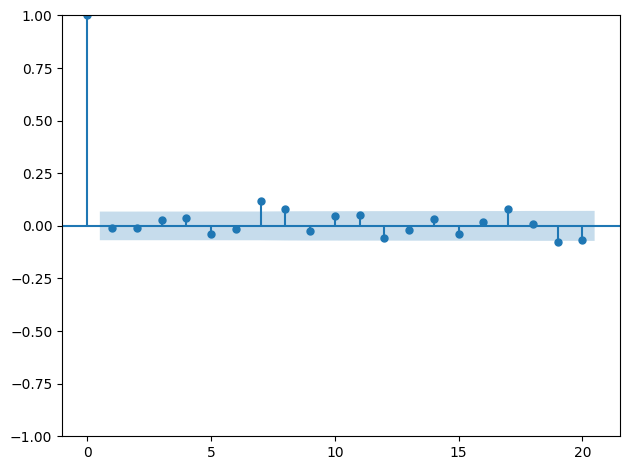

In [63]:
plot_acf(resid_arma,lags=20, title="");
        #   title='Função de Autocorrelação (FAC) do quadrado dos Retornos');
plt.tight_layout()

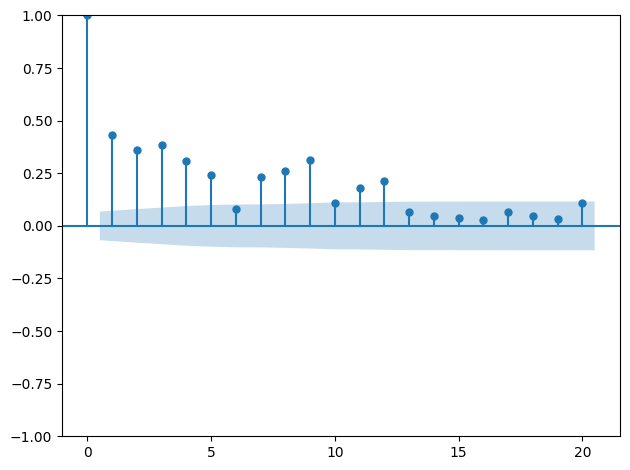

In [64]:
plot_acf(resid_arma**2,lags=20, title="");
        #   title='Função de Autocorrelação (FAC) do quadrado dos Retornos');
plt.tight_layout()

### GARCH MODELS

some Util links
- https://www.oreilly.com/library/view/machine-learning-for/9781492085249/ch04.html
- https://users.metu.edu.tr/home402/ozancan/wwwhome/ARCHGARCHTutorial.html
- https://bibliotecadigital.fgv.br/dspace/bitstream/handle/10438/10014/TD%20313%20-%20CEQEF%2003%20-%20Marcos%20Vinicio%20Wink%20Junior%20e%20%20Pedro%20Valls.pdf?sequence=1
- https://repositorio.ufc.br/bitstream/riufc/39729/1/2018_tcc_wlalves.pdf
- file:///C:/Users/Gabriel/Downloads/paulo%20thomaz.pdf

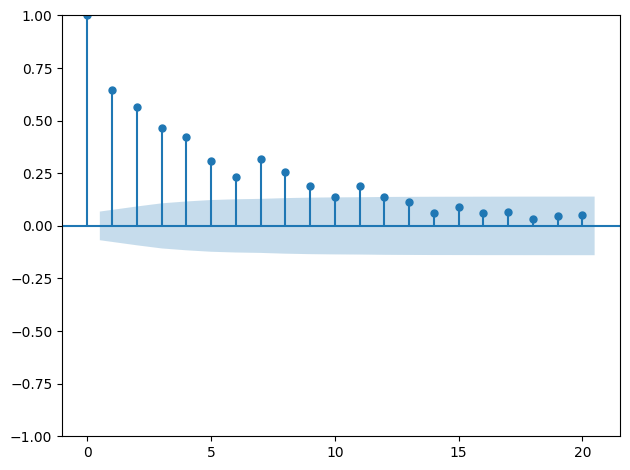

In [65]:
plot_acf(r_train**2,lags=20, title="");
        #   title='Função de Autocorrelação (FAC) do quadrado dos Retornos');
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'fac-return-squared.jpg'), dpi=300, bbox_inches='tight')

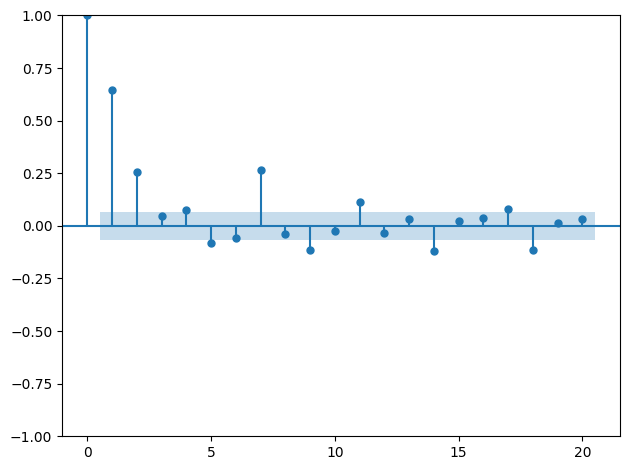

In [66]:
plot_pacf(r_train**2, lags=20, title="")
        #   title='Função de Autocorrelação Parcial (FACP) do quadrado dos Retornos\n(Treinamento)');
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'facp-return-squared.jpg'), dpi=300, bbox_inches='tight')

Verifica-se pelo quadrado dos retornos que o modelo ARCH é adaquado

### GARCH

In [67]:
from arch import arch_model

ARMA-GARCH

In [68]:
arma_gm_11 = arch_model(resid_arma, p=1, q=1)
result_arma_gm_11 = arma_gm_11.fit(disp='off')
arma_gm_12 = arch_model(resid_arma, p=1, q=2)
result_arma_gm_12 = arma_gm_12.fit(disp='off')
arma_gm_21 = arch_model(resid_arma, p=2, q=1)
result_arma_gm_21 = arma_gm_21.fit(disp='off')
arma_gm_22 = arch_model(resid_arma, p=2, q=2)
result_arma_gm_22 = arma_gm_22.fit(disp='off')

log_garch(result_arma_gm_11, "ARMA-GARCH (1,1) - Normal")
log_garch(result_arma_gm_12, "ARMA-GARCH (1,2) - Normal")
log_garch(result_arma_gm_21, "ARMA-GARCH (2,1) - Normal")
log_garch(result_arma_gm_22, "ARMA-GARCH (2,2) - Normal")

,AIC,BIC,LB,LB(r²),ARCH,SW
"ARMA-GARCH (1,1) - Normal",2955.018482,2973.894535,0.001143,0.172702,0.175508,6.316040e-09
"ARMA-GARCH (1,2) - Normal",2956.936895,2980.531961,0.001177,0.171417,0.172916,6.960452e-09
"ARMA-GARCH (2,1) - Normal",2957.018483,2980.613549,0.001143,0.172726,0.175530,6.320434e-09
"ARMA-GARCH (2,2) - Normal",2958.891056,2987.205135,0.001076,0.130804,0.134286,5.433234e-09


In [69]:
arma_gm_student_11 = arch_model(resid_arma, p=1, q=1)
result_arma_gm_student_11 = arma_gm_student_11.fit(disp='off')
arma_gm_student_12 = arch_model(resid_arma, p=1, q=2)
result_arma_gm_student_12 = arma_gm_student_12.fit(disp='off')
arma_gm_student_21 = arch_model(resid_arma, p=2, q=1)
result_arma_gm_student_21 = arma_gm_student_21.fit(disp='off')
arma_gm_student_22 = arch_model(resid_arma, p=2, q=2)
result_arma_gm_student_22 = arma_gm_student_22.fit(disp='off')

log_garch(result_arma_gm_student_11, "ARMA-GARCH (1,1) - Student", False)
log_garch(result_arma_gm_student_12, "ARMA-GARCH (1,2) - Student", False)
log_garch(result_arma_gm_student_21, "ARMA-GARCH (2,1) - Student", False)
log_garch(result_arma_gm_student_22, "ARMA-GARCH (2,2) - Student", False)

,AIC,BIC,LB,LB(r²),ARCH,SW
"ARMA-GARCH (1,1) - Normal",2955.018482,2973.894535,0.001143,0.172702,0.175508,6.316040e-09
"ARMA-GARCH (1,2) - Normal",2956.936895,2980.531961,0.001177,0.171417,0.172916,6.960452e-09
"ARMA-GARCH (2,1) - Normal",2957.018483,2980.613549,0.001143,0.172726,0.175530,6.320434e-09
"ARMA-GARCH (2,2) - Normal",2958.891056,2987.205135,0.001076,0.130804,0.134286,5.433234e-09
"ARMA-GARCH (1,1) - Student",2955.018482,2973.894535,0.001143,0.172702,0.175508,NaN
"ARMA-GARCH (1,2) - Student",2956.936895,2980.531961,0.001177,0.171417,0.172916,NaN
"ARMA-GARCH (2,1) - Student",2957.018483,2980.613549,0.001143,0.172726,0.175530,NaN
"ARMA-GARCH (2,2) - Student",2958.891056,2987.205135,0.001076,0.130804,0.134286,NaN


ARX-GARCH

In [248]:
arxgm_11 = arch_model(r_train, x=covid_train, mean="ARX", p=1, q=1, dist="normal")
result_arxgm_11 = arxgm_11.fit(disp='off')
arxgm_12 = arch_model(r_train, x=covid_train, mean="ARX", p=1, q=2, dist="normal")
result_arxgm_12 = arxgm_12.fit(disp='off')
arxgm_21 = arch_model(r_train,x=covid_train, mean="ARX", p=2, q=1, dist="normal")
result_arxgm_21 = arxgm_21.fit(disp='off')
arxgm_22 = arch_model(r_train, x=covid_train, mean="ARX",p=2, q=2, dist="normal")
result_arxgm_22 = arxgm_22.fit(disp='off')
arxgm_10 = arch_model(r_train, x=covid_train, mean="ARX", p=1, q=0, dist="normal")
result_arxgm_10 = arxgm_10.fit(disp='off')

In [250]:
result_arxgm_11

                          AR-X - GARCH Model Results                          
Dep. Variable:                returns   R-squared:                      -0.002
Mean Model:                      AR-X   Adj. R-squared:                 -0.003
Vol Model:                      GARCH   Log-Likelihood:               -1466.77
Distribution:                  Normal   AIC:                           2943.53
Method:            Maximum Likelihood   BIC:                           2967.13
                                        No. Observations:                  828
Date:                Mon, Mar 27 2023   Df Residuals:                      826
Time:                        17:00:38   Df Model:                            2
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.2266      0.114      1.985  4.714e-02 [2.866e-0

In [251]:
log_garch(result_arxgm_11, "ARX-GARCH (1,1) - Normal")
log_garch(result_arxgm_12, "ARX-GARCH (1,2) - Normal")
log_garch(result_arxgm_21, "ARX-GARCH (2,1) - Normal")
log_garch(result_arxgm_22, "ARX-GARCH (2,2) - Normal")

,AIC,BIC,LB,LB(r²),ARCH,SW
"ARMA-GARCH (1,1) - Normal",2955.018482,2973.894535,0.001143,0.172702,0.175508,6.316040e-09
"ARMA-GARCH (1,2) - Normal",2956.936895,2980.531961,0.001177,0.171417,0.172916,6.960452e-09
"ARMA-GARCH (2,1) - Normal",2957.018483,2980.613549,0.001143,0.172726,0.175530,6.320434e-09
"ARMA-GARCH (2,2) - Normal",2958.891056,2987.205135,0.001076,0.130804,0.134286,5.433234e-09
"ARMA-GARCH (1,1) - Student",2955.018482,2973.894535,0.001143,0.172702,0.175508,NaN
"ARMA-GARCH (1,2) - Student",2956.936895,2980.531961,0.001177,0.171417,0.172916,NaN
"ARMA-GARCH (2,1) - Student",2957.018483,2980.613549,0.001143,0.172726,0.175530,NaN
"ARMA-GARCH (2,2) - Student",2958.891056,2987.205135,0.001076,0.130804,0.134286,NaN
"GARCH (1,1) - Normal",2942.663685,2961.539738,0.109785,0.186433,0.200609,2.239904e-09
"GARCH (1,2) - Normal",2944.566569,2968.161635,0.112693,0.169252,0.180824,2.200102e-09


In [264]:
arxgm_student_11 = arch_model(y=r_train, x=covid_train, mean="ARX", p=1, q=1, dist="StudentsT", vol="GARCH")
result_arxgm_student_11 = arxgm_student_11.fit(disp='off')
arxgm_student_12 = arch_model(r_train, x=covid_train, mean="ARX", p=1, q=2, dist="StudentsT")
result_arxgm_student_12 = arxgm_student_12.fit(disp='off')
arxgm_student_21 = arch_model(r_train,x=covid_train, mean="ARX", p=2, q=1, dist="StudentsT")
result_arxgm_student_21 = arxgm_student_21.fit(disp='off')
arxgm_student_22 = arch_model(r_train, x=covid_train, mean="ARX",p=2, q=2, dist="StudentsT")
result_arxgm_student_22 = arxgm_student_22.fit(disp='off')
arxgm_student_10 = arch_model(r_train, x=covid_train, mean="ARX", p=1, q=0, dist="StudentsT")
result_arxgm_student_10 = arxgm_student_10.fit(disp='off')

In [265]:
result_arxgm_student_11

                             AR-X - GARCH Model Results                             
Dep. Variable:                      returns   R-squared:                      -0.002
Mean Model:                            AR-X   Adj. R-squared:                 -0.004
Vol Model:                            GARCH   Log-Likelihood:               -1452.03
Distribution:      Standardized Student's t   AIC:                           2916.07
Method:                  Maximum Likelihood   BIC:                           2944.38
                                              No. Observations:                  828
Date:                      Mon, Mar 27 2023   Df Residuals:                      826
Time:                              17:08:06   Df Model:                            2
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const  

In [266]:
log_garch(result_arxgm_student_11, "ARX-GARCH (1,1) - Student")
log_garch(result_arxgm_student_12, "ARX-GARCH (1,2) - Student")
log_garch(result_arxgm_student_21, "ARX-GARCH (2,1) - Student")
log_garch(result_arxgm_student_22, "ARX-GARCH (2,2) - Student")

,AIC,BIC,LB,LB(r²),ARCH,SW
"ARMA-GARCH (1,1) - Normal",2955.018482,2973.894535,0.001143,0.172702,0.175508,6.316040e-09
"ARMA-GARCH (1,2) - Normal",2956.936895,2980.531961,0.001177,0.171417,0.172916,6.960452e-09
"ARMA-GARCH (2,1) - Normal",2957.018483,2980.613549,0.001143,0.172726,0.175530,6.320434e-09
"ARMA-GARCH (2,2) - Normal",2958.891056,2987.205135,0.001076,0.130804,0.134286,5.433234e-09
"ARMA-GARCH (1,1) - Student",2955.018482,2973.894535,0.001143,0.172702,0.175508,NaN
"ARMA-GARCH (1,2) - Student",2956.936895,2980.531961,0.001177,0.171417,0.172916,NaN
"ARMA-GARCH (2,1) - Student",2957.018483,2980.613549,0.001143,0.172726,0.175530,NaN
"ARMA-GARCH (2,2) - Student",2958.891056,2987.205135,0.001076,0.130804,0.134286,NaN
"GARCH (1,1) - Normal",2942.663685,2961.539738,0.109785,0.186433,0.200609,2.239904e-09
"GARCH (1,2) - Normal",2944.566569,2968.161635,0.112693,0.169252,0.180824,2.200102e-09


In [240]:
arxgm_student_11_preds = expading_window_forecast_garch(lambda train, covid: arch_model(train, x=covid, mean="ARX", p=1, q=1, dist="StudentsT"), True )
scaler_garch_student_11, scaled_arx_cond_vol_student_11 = scale_tf_cond_vol(result_arxgm_student_11)
arxgm_student_11_preds_scaled = transform_volatility_to_scaler(scaler_garch_student_11, arxgm_student_11_preds)
log_perf(y_val_scaled, arxgm_student_11_preds_scaled,'ARX-GARCH(1,1) - Student')

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000518,0.742846,0.022763,0.326157
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000437,0.630741,0.020905,0.291224
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000864,0.986822,0.029394,0.438549
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000560,0.379279,0.023654,0.280776


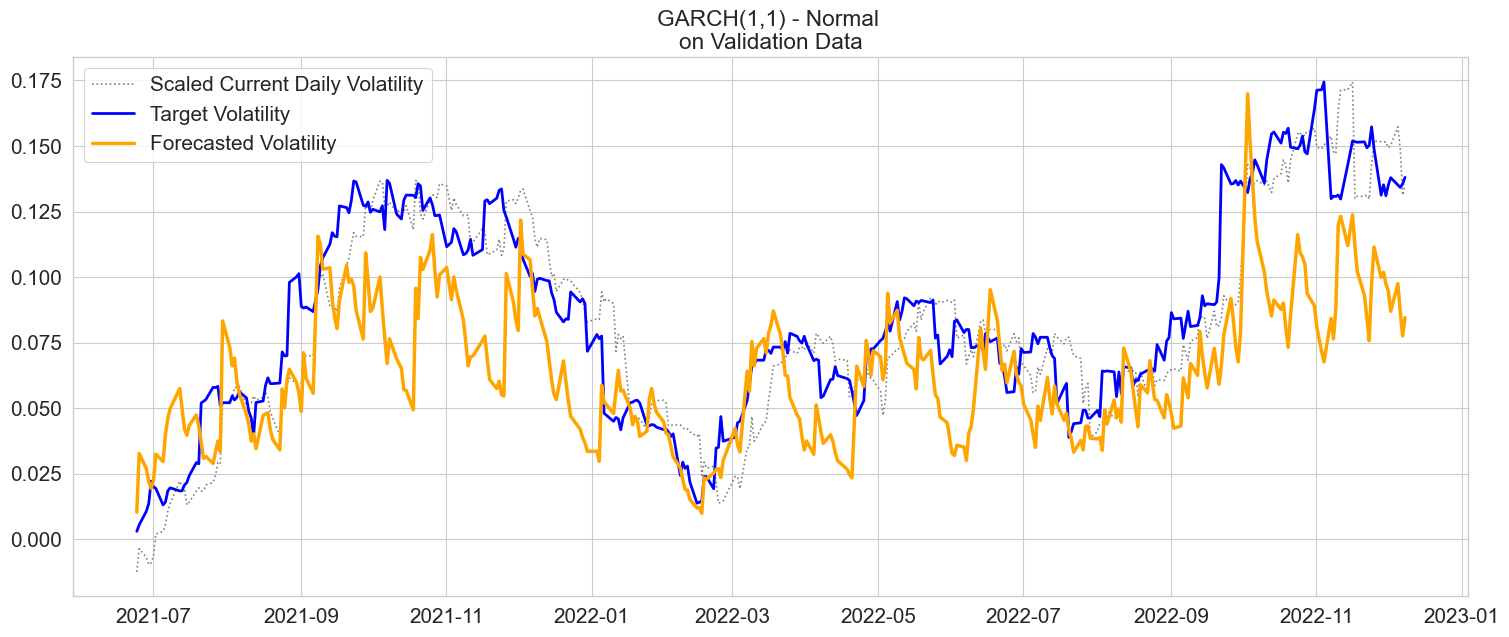

In [244]:
viz_model(y_val_scaled, arxgm_student_11_preds_scaled, 'GARCH(1,1) - Normal')

### GArch


In [70]:
gm_11 = arch_model(r_train, p=1, q=1, dist="normal")
result_11 = gm_11.fit(disp='off')
gm_12 = arch_model(r_train, p=1, q=2, dist="normal")
result_12 = gm_12.fit(disp='off')
gm_21 = arch_model(r_train, p=2, q=1, dist="normal")
result_21 = gm_21.fit(disp='off')
gm_22 = arch_model(r_train, p=2, q=2, dist="normal")
result_22 = gm_22.fit(disp='off')
gm_10 = arch_model(r_train, p=1, q=0, dist="normal")
result_10 = gm_10.fit(disp='off')

In [71]:
het_arch(result_11.std_resid)

(13.430085265120779,
 0.20060906244258284,
 1.3470648865268364,
 0.20084459811747968)

In [72]:
acorr_ljungbox(result_11.std_resid**2, lags=[10])

,lb_stat,lb_pvalue
10,13.714166,0.186433


In [73]:
result_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1467.33
Distribution:                  Normal   AIC:                           2942.66
Method:            Maximum Likelihood   BIC:                           2961.54
                                        No. Observations:                  828
Date:                Mon, Mar 27 2023   Df Residuals:                      827
Time:                        15:52:45   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1169  4.323e-02      2.705  6.839e-03 [3.219e-02,  0.202]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1078  4.336e-02      2.486  1.291e-02 [2.282e-02,  0.193]
alpha[1]       0.1195  3.478e-02      3.435  5.920e-04 [5.131e-02,  0.188]
beta[1]        0.8356  4.024e-02     20.768  8.462e-96   [  0.757,  0.914]
==========================================================================

Covariance estimator: robust
"""

In [74]:
log_garch(result_11, "GARCH (1,1) - Normal")
log_garch(result_12, "GARCH (1,2) - Normal")
log_garch(result_21, "GARCH (2,1) - Normal")
log_garch(result_22, "GARCH (2,2) - Normal")

,AIC,BIC,LB,LB(r²),ARCH,SW
"ARMA-GARCH (1,1) - Normal",2955.018482,2973.894535,0.001143,0.172702,0.175508,6.316040e-09
"ARMA-GARCH (1,2) - Normal",2956.936895,2980.531961,0.001177,0.171417,0.172916,6.960452e-09
"ARMA-GARCH (2,1) - Normal",2957.018483,2980.613549,0.001143,0.172726,0.175530,6.320434e-09
"ARMA-GARCH (2,2) - Normal",2958.891056,2987.205135,0.001076,0.130804,0.134286,5.433234e-09
"ARMA-GARCH (1,1) - Student",2955.018482,2973.894535,0.001143,0.172702,0.175508,NaN
"ARMA-GARCH (1,2) - Student",2956.936895,2980.531961,0.001177,0.171417,0.172916,NaN
"ARMA-GARCH (2,1) - Student",2957.018483,2980.613549,0.001143,0.172726,0.175530,NaN
"ARMA-GARCH (2,2) - Student",2958.891056,2987.205135,0.001076,0.130804,0.134286,NaN
"GARCH (1,1) - Normal",2942.663685,2961.539738,0.109785,0.186433,0.200609,2.239904e-09
"GARCH (1,2) - Normal",2944.566569,2968.161635,0.112693,0.169252,0.180824,2.200102e-09


Utilizando nivel de significande de 0.05, nenhum dos coefieficientes para os modelos (1,2), (2,1), (2,2) parecem ser estatisticamente significante, já que o os seus p-values `P > |t|` são todos maiores que 0.05. diferente do GARCH (1,1)

É possivel verificar que que pelo test `Shapiro Wilk (SW)`, `p-value` é menor que 0.05, portanto é rejeita-se a hipotese nula e assim, temos evidencia suficiente para dizer que não segue uma distribuição normal, o que é comum para series financeiras, porém o modelo garch permite setar a distribuição como T Student , 

In [75]:
gm_student_11 = arch_model(r_train, p=1, q=1, dist="StudentsT")
result_student_11 = gm_student_11.fit(disp='off')
gm_student_22 = arch_model(r_train, p=2, q=2, dist="StudentsT")
result_student_22 = gm_student_22.fit(disp='off')
gm_student_12 = arch_model(r_train, p=1, q=2, dist="StudentsT")
result_student_12 = gm_student_12.fit(disp='off')
gm_student_21 = arch_model(r_train, p=2, q=1, dist="StudentsT")
result_student_21 = gm_student_21.fit(disp='off')

In [76]:
result_student_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1452.46
Distribution:      Standardized Student's t   AIC:                           2914.91
Method:                  Maximum Likelihood   BIC:                           2938.51
                                              No. Observations:                  828
Date:                      Mon, Mar 27 2023   Df Residuals:                      827
Time:                              15:52:45   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1309  4.184e-02      3.129  1.757e-03 [4.889e-02,  0.213]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.0925  3.588e-02      2.579  9.906e-03 [2.221e-02,  0.163]
alpha[1]       0.1122  2.711e-02      4.140  3.474e-05 [5.910e-02,  0.165]
beta[1]        0.8483  3.302e-02     25.688 1.572e-145   [  0.784,  0.913]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             8.6317      2.379      3.628  2.858e-04 [  3.968, 13.295]
========================================================================

Covariance estimator: robust
"""

In [77]:
log_garch(result_student_11, "GARCH (1,1) - Student", False)
log_garch(result_student_12, "GARCH (1,2) - Student", False)
log_garch(result_student_21, "GARCH (2,1) - Student", False)
log_garch(result_student_22, "GARCH (2,2) - Student", False)

,AIC,BIC,LB,LB(r²),ARCH,SW
"ARMA-GARCH (1,1) - Normal",2955.018482,2973.894535,0.001143,0.172702,0.175508,6.316040e-09
"ARMA-GARCH (1,2) - Normal",2956.936895,2980.531961,0.001177,0.171417,0.172916,6.960452e-09
"ARMA-GARCH (2,1) - Normal",2957.018483,2980.613549,0.001143,0.172726,0.175530,6.320434e-09
"ARMA-GARCH (2,2) - Normal",2958.891056,2987.205135,0.001076,0.130804,0.134286,5.433234e-09
"ARMA-GARCH (1,1) - Student",2955.018482,2973.894535,0.001143,0.172702,0.175508,NaN
"ARMA-GARCH (1,2) - Student",2956.936895,2980.531961,0.001177,0.171417,0.172916,NaN
"ARMA-GARCH (2,1) - Student",2957.018483,2980.613549,0.001143,0.172726,0.175530,NaN
"ARMA-GARCH (2,2) - Student",2958.891056,2987.205135,0.001076,0.130804,0.134286,NaN
"GARCH (1,1) - Normal",2942.663685,2961.539738,0.109785,0.186433,0.200609,2.239904e-09
"GARCH (1,2) - Normal",2944.566569,2968.161635,0.112693,0.169252,0.180824,2.200102e-09


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


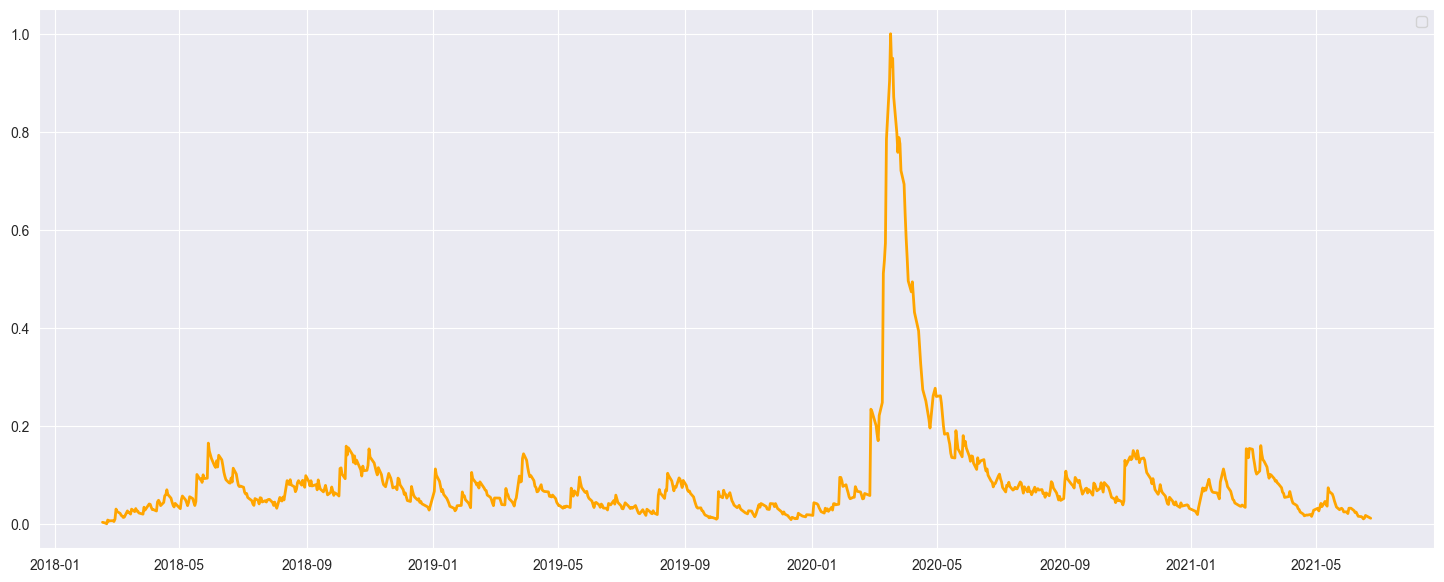

In [78]:
scaler_garch_student_11, scaled_cond_vol_student_11 = scale_tf_cond_vol(result_student_11)
viz_only_cond_vol(scaled_cond_vol_student_11, 'GARCH(1,1) - t de Student', True)


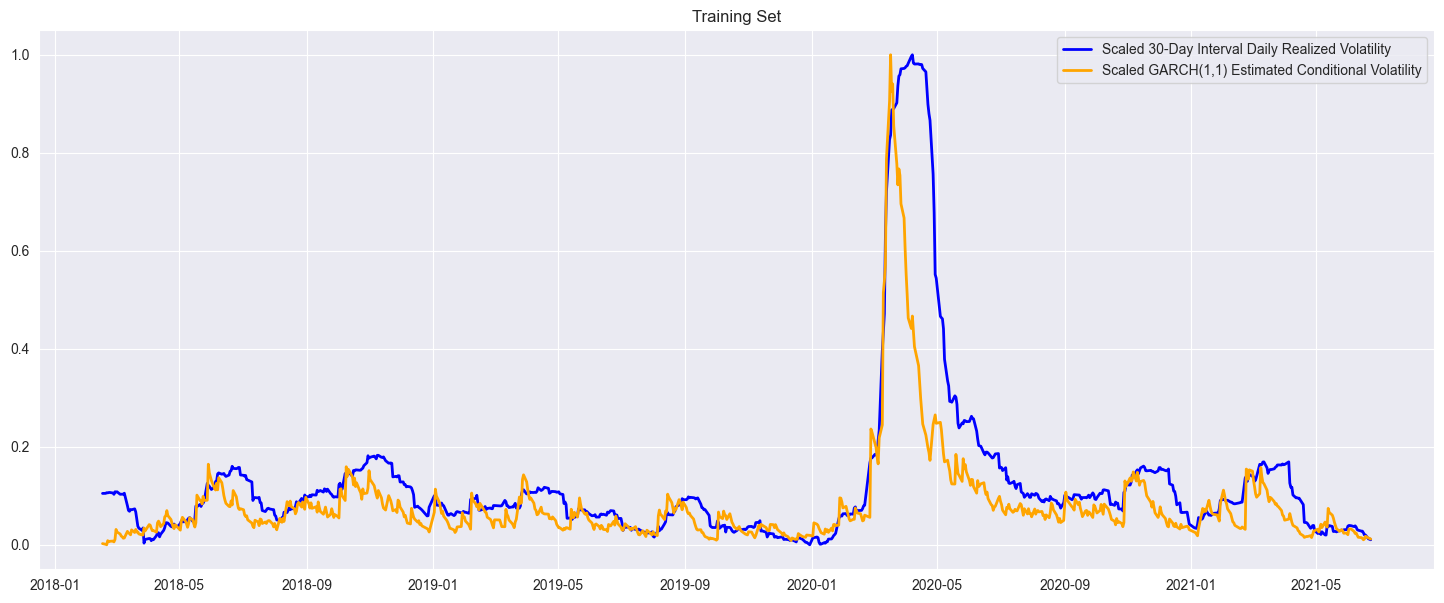

In [79]:
scaler_garch_11, scaled_cond_vol_11 = scale_tf_cond_vol(result_11)
viz_cond_vol(scaled_cond_vol_11, 'GARCH(1,1)')

### Expanding Window Forecasting

Será dada a previsão para os próximo dias futuros `n_future = 14` e assim deve-se reajustar o modelo para cada passo no tempo.


In [81]:
gm_11_preds = expading_window_forecast_garch(lambda train: arch_model(train, vol='GARCH', p=1, q=1) )

In [82]:
gm_11_preds_scaled = transform_volatility_to_scaler(scaler_garch_11, gm_11_preds)

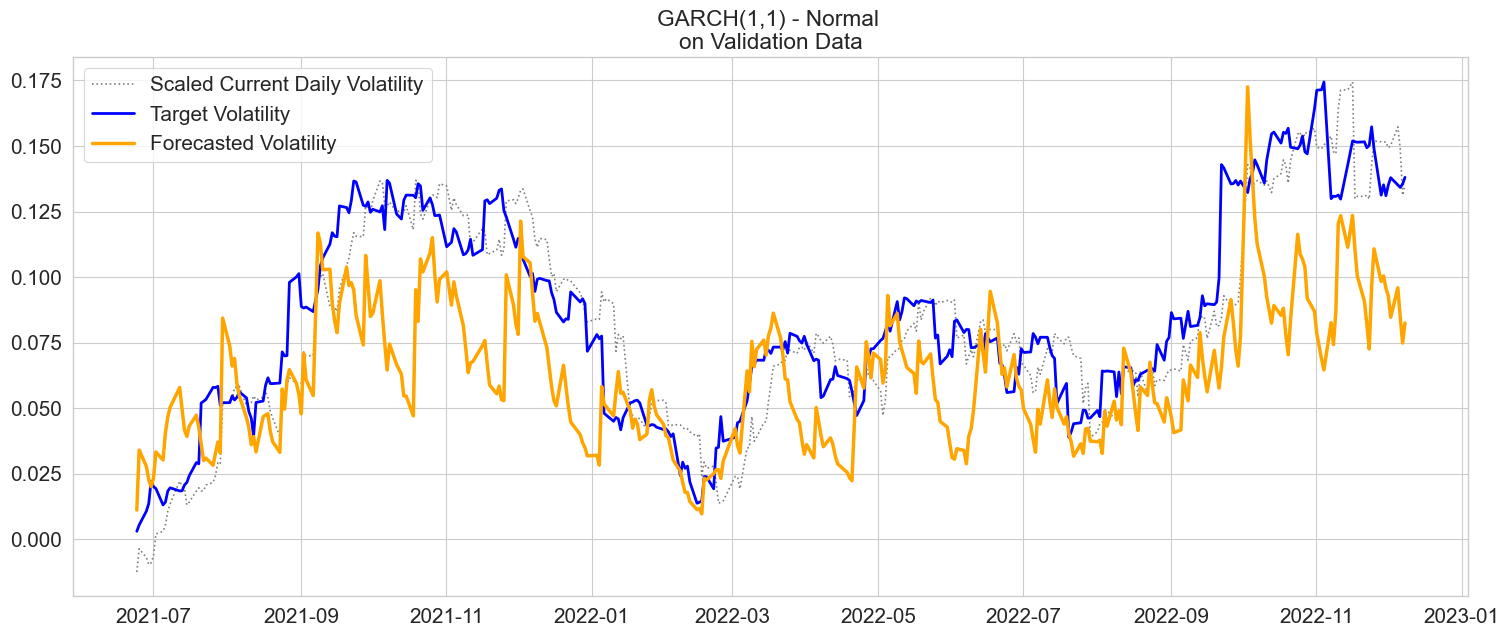

In [83]:
viz_model(y_val_scaled, gm_11_preds_scaled, 'GARCH(1,1) - Normal')

In [84]:
log_perf(y_val_scaled, gm_11_preds_scaled,'GARCH(1,1) - Normal')

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772


In [85]:
log_perf(y_val_scaled, gm_11_preds_scaled,'GARCH(1,1) - Normal')

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772


In [86]:
gm_student_11_preds = expading_window_forecast_garch(lambda train: arch_model(train, vol='GARCH', p=1, q=1, dist="StudentsT") )
scaler_garch_student_11, scaled_cond_vol_student_11 = scale_tf_cond_vol(result_student_11)
gm_student_11_preds_scaled = transform_volatility_to_scaler(scaler_garch_student_11, gm_student_11_preds)
log_perf(y_val_scaled, gm_student_11_preds_scaled,'GARCH(1,1) - Student')

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151


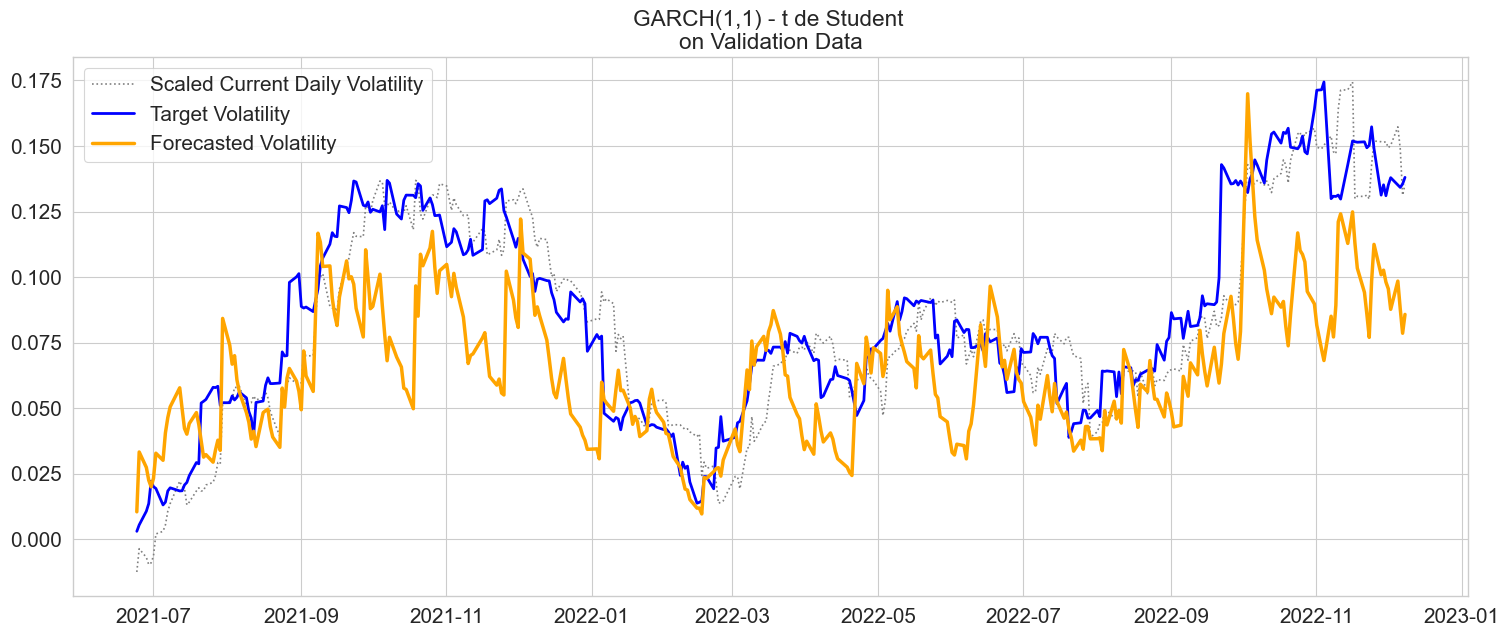

In [87]:
viz_model(y_val_scaled, gm_student_11_preds_scaled, 'GARCH(1,1) - t de Student', True)

### Garch Model with asymmetric shock response

In [88]:
gjr_gm_11 = arch_model(r_train, p=1, q=1, o=1, vol='GARCH')
result_gjr_gm_11 = gjr_gm_11.fit(disp='off')
gjr_gm_22 = arch_model(r_train, p=2, q=2, o=1, vol='GARCH')
result_gjr_gm_22 = gjr_gm_22.fit(disp='off')
gjr_gm_21 = arch_model(r_train, p=2, q=1, o=1, vol='GARCH')
result_gjr_gm_21 = gjr_gm_21.fit(disp='off')
gjr_gm_12 = arch_model(r_train, p=1, q=2, o=1, vol='GARCH')
result_gjr_gm_12 = gjr_gm_12.fit(disp='off')

In [89]:
result_gjr_gm_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1460.55
Distribution:                  Normal   AIC:                           2931.11
Method:            Maximum Likelihood   BIC:                           2954.70
                                        No. Observations:                  828
Date:                Mon, Mar 27 2023   Df Residuals:                      827
Time:                        15:53:12   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0860  4.451e-02      1.932  5.338e-02 [-1.254e-03,  0.173]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1139  4.951e-02      2.301  2.137e-02    [1.690e-02,  0.211]
alpha[1]       0.0350  2.551e-02      1.373      0.170 [-1.498e-02,8.502e-02]
gamma[1]       0.1355  5.786e-02      2.341  1.921e-02    [2.207e-02,  0.249]
beta[1]        0.8448  4.766e-02     17.725  2.694e-70      [  0.751,  0.938]
=============================================================================

Covariance estimator: robust
"""

In [90]:
log_garch(result_gjr_gm_11, "GJR-GARCH (1,1) - Normal")
log_garch(result_gjr_gm_12, "GJR-GARCH (1,2) - Normal")
log_garch(result_gjr_gm_21, "GJR-GARCH (2,1) - Normal")
log_garch(result_gjr_gm_22, "GJR-GARCH (2,2) - Normal")

,AIC,BIC,LB,LB(r²),ARCH,SW
"ARMA-GARCH (1,1) - Normal",2955.018482,2973.894535,0.001143,0.172702,0.175508,6.316040e-09
"ARMA-GARCH (1,2) - Normal",2956.936895,2980.531961,0.001177,0.171417,0.172916,6.960452e-09
"ARMA-GARCH (2,1) - Normal",2957.018483,2980.613549,0.001143,0.172726,0.175530,6.320434e-09
"ARMA-GARCH (2,2) - Normal",2958.891056,2987.205135,0.001076,0.130804,0.134286,5.433234e-09
"ARMA-GARCH (1,1) - Student",2955.018482,2973.894535,0.001143,0.172702,0.175508,NaN
"ARMA-GARCH (1,2) - Student",2956.936895,2980.531961,0.001177,0.171417,0.172916,NaN
"ARMA-GARCH (2,1) - Student",2957.018483,2980.613549,0.001143,0.172726,0.175530,NaN
"ARMA-GARCH (2,2) - Student",2958.891056,2987.205135,0.001076,0.130804,0.134286,NaN
"GARCH (1,1) - Normal",2942.663685,2961.539738,0.109785,0.186433,0.200609,2.239904e-09
"GARCH (1,2) - Normal",2944.566569,2968.161635,0.112693,0.169252,0.180824,2.200102e-09


In [91]:
gjr_gm_student_11 = arch_model(r_train, p=1, q=1, o=1, vol='GARCH', dist='StudentsT')
result_gjr_gm_student_11 = gjr_gm_student_11.fit(disp='off')
gjr_gm_student_22 = arch_model(r_train, p=2, q=2, o=1, vol='GARCH', dist='StudentsT')
result_gjr_gm_student_22 = gjr_gm_student_22.fit(disp='off')
gjr_gm_student_21 = arch_model(r_train, p=2, q=1, o=1, vol='GARCH', dist='StudentsT')
result_gjr_gm_student_21 = gjr_gm_student_21.fit(disp='off')
gjr_gm_student_12 = arch_model(r_train, p=1, q=2, o=1, vol='GARCH', dist='StudentsT')
result_gjr_gm_student_12 = gjr_gm_student_12.fit(disp='off')

In [92]:
result_gjr_gm_student_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GJR-GARCH Model Results                       
====================================================================================
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1448.29
Distribution:      Standardized Student's t   AIC:                           2908.57
Method:                  Maximum Likelihood   BIC:                           2936.89
                                              No. Observations:                  828
Date:                      Mon, Mar 27 2023   Df Residuals:                      827
Time:                              15:53:12   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1054  4.341e-02      2.428  1.519e-02 [2.030e-02,  0.190]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1003  4.307e-02      2.329  1.984e-02    [1.591e-02,  0.185]
alpha[1]       0.0390  2.393e-02      1.629      0.103 [-7.928e-03,8.588e-02]
gamma[1]       0.1208  5.109e-02      2.364  1.806e-02    [2.066e-02,  0.221]
beta[1]        0.8527  4.067e-02     20.964  1.397e-97      [  0.773,  0.932]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             9.1040      2.583      3.524  4.252e-04 [  4.041, 14.168]
========================================================================

Covariance estimator: robust
"""

In [93]:
log_garch(result_gjr_gm_student_11, "GJR-GARCH (1,1) - Student", False)
log_garch(result_gjr_gm_student_12, "GJR-GARCH (1,2) - Student", False)
log_garch(result_gjr_gm_student_21, "GJR-GARCH (2,1) - Student", False)
log_garch(result_gjr_gm_student_22, "GJR-GARCH (2,2) - Student", False)

,AIC,BIC,LB,LB(r²),ARCH,SW
"ARMA-GARCH (1,1) - Normal",2955.018482,2973.894535,0.001143,0.172702,0.175508,6.316040e-09
"ARMA-GARCH (1,2) - Normal",2956.936895,2980.531961,0.001177,0.171417,0.172916,6.960452e-09
"ARMA-GARCH (2,1) - Normal",2957.018483,2980.613549,0.001143,0.172726,0.175530,6.320434e-09
"ARMA-GARCH (2,2) - Normal",2958.891056,2987.205135,0.001076,0.130804,0.134286,5.433234e-09
"ARMA-GARCH (1,1) - Student",2955.018482,2973.894535,0.001143,0.172702,0.175508,NaN
"ARMA-GARCH (1,2) - Student",2956.936895,2980.531961,0.001177,0.171417,0.172916,NaN
"ARMA-GARCH (2,1) - Student",2957.018483,2980.613549,0.001143,0.172726,0.175530,NaN
"ARMA-GARCH (2,2) - Student",2958.891056,2987.205135,0.001076,0.130804,0.134286,NaN
"GARCH (1,1) - Normal",2942.663685,2961.539738,0.109785,0.186433,0.200609,2.239904e-09
"GARCH (1,2) - Normal",2944.566569,2968.161635,0.112693,0.169252,0.180824,2.200102e-09


### TARCH

In [94]:

np.random.seed(seed)
t_gm_11 = arch_model(r_train, p=1, o=1, q=1, power=1.0, dist='normal')
result_t_gm_11 = t_gm_11.fit(disp='off')
t_gm_22 = arch_model(r_train, p=2, o=1, q=2, power=1.0, dist='normal')
result_t_gm_22 = t_gm_22.fit(disp='off')
t_gm_21 = arch_model(r_train, p=2, o=1, q=1, power=1.0, dist='normal')
result_t_gm_21 = t_gm_21.fit(disp='off')
t_gm_12 = arch_model(r_train, p=1, o=1, q=2, power=1.0, dist='normal')
result_t_gm_12 = t_gm_12.fit(disp='off')

In [95]:
result_t_gm_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Constant Mean - TARCH/ZARCH Model Results                   
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -1454.01
Distribution:                  Normal   AIC:                           2918.02
Method:            Maximum Likelihood   BIC:                           2941.62
                                        No. Observations:                  828
Date:                Mon, Mar 27 2023   Df Residuals:                      827
Time:                        15:53:13   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0925  6.985e-04    132.360      0.000 [9.109e-02,9.382e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0886  3.671e-02      2.412  1.585e-02    [1.661e-02,  0.161]
alpha[1]       0.0459  2.750e-02      1.669  9.507e-02 [-7.996e-03,9.981e-02]
gamma[1]       0.1652  4.990e-02      3.310  9.346e-04    [6.735e-02,  0.263]
beta[1]        0.8386  4.696e-02     17.856  2.578e-71      [  0.747,  0.931]
=============================================================================

Covariance estimator: robust
"""

In [96]:
log_garch(result_t_gm_11, "TARCH (1,1) - Normal")
log_garch(result_t_gm_12, "TARCH (1,2) - Normal")
log_garch(result_t_gm_21, "TARCH (2,1) - Normal")
log_garch(result_t_gm_22, "TARCH (2,2) - Normal")

,AIC,BIC,LB,LB(r²),ARCH,SW
"ARMA-GARCH (1,1) - Normal",2955.018482,2973.894535,0.001143,0.172702,0.175508,6.316040e-09
"ARMA-GARCH (1,2) - Normal",2956.936895,2980.531961,0.001177,0.171417,0.172916,6.960452e-09
"ARMA-GARCH (2,1) - Normal",2957.018483,2980.613549,0.001143,0.172726,0.175530,6.320434e-09
"ARMA-GARCH (2,2) - Normal",2958.891056,2987.205135,0.001076,0.130804,0.134286,5.433234e-09
"ARMA-GARCH (1,1) - Student",2955.018482,2973.894535,0.001143,0.172702,0.175508,NaN
"ARMA-GARCH (1,2) - Student",2956.936895,2980.531961,0.001177,0.171417,0.172916,NaN
"ARMA-GARCH (2,1) - Student",2957.018483,2980.613549,0.001143,0.172726,0.175530,NaN
"ARMA-GARCH (2,2) - Student",2958.891056,2987.205135,0.001076,0.130804,0.134286,NaN
"GARCH (1,1) - Normal",2942.663685,2961.539738,0.109785,0.186433,0.200609,2.239904e-09
"GARCH (1,2) - Normal",2944.566569,2968.161635,0.112693,0.169252,0.180824,2.200102e-09


In [97]:
np.random.seed(seed)
t_gm_student_11 = arch_model(r_train, p=1, o=1, q=1, power=1.0, dist='StudentsT')
result_t_gm_student_11 = t_gm_student_11.fit(disp='off')
t_gm_student_22 = arch_model(r_train, p=2, o=1, q=2, power=1.0, dist='StudentsT')
result_t_gm_student_22 = t_gm_student_22.fit(disp='off')
t_gm_student_21 = arch_model(r_train, p=2, o=1, q=1, power=1.0, dist='StudentsT')
result_t_gm_student_21 = t_gm_student_21.fit(disp='off')
t_gm_student_12 = arch_model(r_train, p=1, o=1, q=2, power=1.0, dist='StudentsT')
result_t_gm_student_12 = t_gm_student_12.fit(disp='off')

In [98]:
log_garch(result_t_gm_student_11, "TARCH (1,1) - Student", False)
log_garch(result_t_gm_student_12, "TARCH (1,2) - Student", False)
log_garch(result_t_gm_student_21, "TARCH (2,1) - Student", False)
log_garch(result_t_gm_student_11, "TARCH (2,2) - Student", False)

,AIC,BIC,LB,LB(r²),ARCH,SW
"ARMA-GARCH (1,1) - Normal",2955.018482,2973.894535,0.001143,0.172702,0.175508,6.316040e-09
"ARMA-GARCH (1,2) - Normal",2956.936895,2980.531961,0.001177,0.171417,0.172916,6.960452e-09
"ARMA-GARCH (2,1) - Normal",2957.018483,2980.613549,0.001143,0.172726,0.175530,6.320434e-09
"ARMA-GARCH (2,2) - Normal",2958.891056,2987.205135,0.001076,0.130804,0.134286,5.433234e-09
"ARMA-GARCH (1,1) - Student",2955.018482,2973.894535,0.001143,0.172702,0.175508,NaN
"ARMA-GARCH (1,2) - Student",2956.936895,2980.531961,0.001177,0.171417,0.172916,NaN
"ARMA-GARCH (2,1) - Student",2957.018483,2980.613549,0.001143,0.172726,0.175530,NaN
"ARMA-GARCH (2,2) - Student",2958.891056,2987.205135,0.001076,0.130804,0.134286,NaN
"GARCH (1,1) - Normal",2942.663685,2961.539738,0.109785,0.186433,0.200609,2.239904e-09
"GARCH (1,2) - Normal",2944.566569,2968.161635,0.112693,0.169252,0.180824,2.200102e-09


### EGARCH

In [99]:
np.random.seed(seed)
e_gm_11 = arch_model(r_train, vol='EGARCH', p=1, o=1, q=1, power=1.0, dist='normal')
result_e_gm_11 = e_gm_11.fit(disp='off')
e_gm_22 = arch_model(r_train, vol='EGARCH', p=2, o=1, q=2, power=1.0, dist='normal')
result_e_gm_22 = e_gm_22.fit(disp='off')
e_gm_21 = arch_model(r_train, vol='EGARCH', p=2, o=1, q=1, power=1.0, dist='normal')
result_e_gm_21 = e_gm_21.fit(disp='off')
e_gm_12 = arch_model(r_train, vol='EGARCH', p=1, o=1, q=2, power=1.0, dist='normal')
result_e_gm_12 = e_gm_12.fit(disp='off')

In [100]:
log_garch(result_e_gm_11, "EGARCH (1,1) - Normal")
log_garch(result_e_gm_12, "EGARCH (1,2) - Normal")
log_garch(result_e_gm_21, "EGARCH (2,1) - Normal")
log_garch(result_e_gm_22, "EGARCH (2,2) - Normal")

,AIC,BIC,LB,LB(r²),ARCH,SW
"ARMA-GARCH (1,1) - Normal",2955.018482,2973.894535,0.001143,0.172702,0.175508,6.316040e-09
"ARMA-GARCH (1,2) - Normal",2956.936895,2980.531961,0.001177,0.171417,0.172916,6.960452e-09
"ARMA-GARCH (2,1) - Normal",2957.018483,2980.613549,0.001143,0.172726,0.175530,6.320434e-09
"ARMA-GARCH (2,2) - Normal",2958.891056,2987.205135,0.001076,0.130804,0.134286,5.433234e-09
"ARMA-GARCH (1,1) - Student",2955.018482,2973.894535,0.001143,0.172702,0.175508,NaN
"ARMA-GARCH (1,2) - Student",2956.936895,2980.531961,0.001177,0.171417,0.172916,NaN
"ARMA-GARCH (2,1) - Student",2957.018483,2980.613549,0.001143,0.172726,0.175530,NaN
"ARMA-GARCH (2,2) - Student",2958.891056,2987.205135,0.001076,0.130804,0.134286,NaN
"GARCH (1,1) - Normal",2942.663685,2961.539738,0.109785,0.186433,0.200609,2.239904e-09
"GARCH (1,2) - Normal",2944.566569,2968.161635,0.112693,0.169252,0.180824,2.200102e-09


In [101]:
np.random.seed(seed)
e_gm_student_11 = arch_model(r_train, vol='EGARCH', p=1, o=1, q=1, power=1.0, dist='StudentsT')
result_e_gm_student_11 = e_gm_student_11.fit(disp='off')
e_gm_student_22 = arch_model(r_train, p=2, o=1, q=2, power=1.0, dist='StudentsT')
result_e_gm_student_22 = e_gm_student_22.fit(disp='off')
e_gm_student_21 = arch_model(r_train, p=2, o=1, q=1, power=1.0, dist='StudentsT')
result_e_gm_student_21 = e_gm_student_21.fit(disp='off')
e_gm_student_12 = arch_model(r_train, p=1, o=1, q=2, power=1.0, dist='StudentsT')
result_e_gm_student_12 = e_gm_student_12.fit(disp='off')

In [102]:
log_garch(result_e_gm_student_11, "EGARCH (1,1) - Student", False)
log_garch(result_e_gm_student_12, "EGARCH (1,2) - Student", False)
log_garch(result_e_gm_student_21, "EGARCH (2,1) - Student", False)
log_garch(result_e_gm_student_11, "EGARCH (2,2) - Student", False)

,AIC,BIC,LB,LB(r²),ARCH,SW
"ARMA-GARCH (1,1) - Normal",2955.018482,2973.894535,0.001143,0.172702,0.175508,6.316040e-09
"ARMA-GARCH (1,2) - Normal",2956.936895,2980.531961,0.001177,0.171417,0.172916,6.960452e-09
"ARMA-GARCH (2,1) - Normal",2957.018483,2980.613549,0.001143,0.172726,0.175530,6.320434e-09
"ARMA-GARCH (2,2) - Normal",2958.891056,2987.205135,0.001076,0.130804,0.134286,5.433234e-09
"ARMA-GARCH (1,1) - Student",2955.018482,2973.894535,0.001143,0.172702,0.175508,NaN
"ARMA-GARCH (1,2) - Student",2956.936895,2980.531961,0.001177,0.171417,0.172916,NaN
"ARMA-GARCH (2,1) - Student",2957.018483,2980.613549,0.001143,0.172726,0.175530,NaN
"ARMA-GARCH (2,2) - Student",2958.891056,2987.205135,0.001076,0.130804,0.134286,NaN
"GARCH (1,1) - Normal",2942.663685,2961.539738,0.109785,0.186433,0.200609,2.239904e-09
"GARCH (1,2) - Normal",2944.566569,2968.161635,0.112693,0.169252,0.180824,2.200102e-09


### Melhores Modelos

In [103]:
analysis_df.sort_values(by='AIC', ascending=True)

,AIC,BIC,LB,LB(r²),ARCH,SW
"TARCH (2,2) - Student",2903.215157,2931.529236,0.164011,0.815734,0.809651,NaN
"TARCH (1,1) - Student",2903.215157,2931.529236,0.164011,0.815734,0.809651,NaN
"EGARCH (2,2) - Student",2904.832728,2933.146807,0.132057,0.838134,0.827873,NaN
"EGARCH (1,1) - Student",2904.832728,2933.146807,0.132057,0.838134,0.827873,NaN
"TARCH (2,1) - Student",2905.094883,2938.127975,0.163642,0.851403,0.846602,NaN
"EGARCH (2,1) - Student",2905.094883,2938.127975,0.163642,0.851403,0.846602,NaN
"EGARCH (1,2) - Student",2905.215157,2938.248250,0.164011,0.815738,0.809654,NaN
"TARCH (1,2) - Student",2905.215157,2938.248250,0.164011,0.815738,0.809654,NaN
"GJR-GARCH (1,1) - Student",2908.573761,2936.887840,0.163843,0.768576,0.754948,NaN
"GJR-GARCH (2,1) - Student",2910.267123,2943.300215,0.162084,0.825080,0.818899,NaN


In [104]:
analysis_df.sort_values(by='BIC', ascending=True)

,AIC,BIC,LB,LB(r²),ARCH,SW
"TARCH (2,2) - Student",2903.215157,2931.529236,0.164011,0.815734,0.809651,NaN
"TARCH (1,1) - Student",2903.215157,2931.529236,0.164011,0.815734,0.809651,NaN
"EGARCH (2,2) - Student",2904.832728,2933.146807,0.132057,0.838134,0.827873,NaN
"EGARCH (1,1) - Student",2904.832728,2933.146807,0.132057,0.838134,0.827873,NaN
"GJR-GARCH (1,1) - Student",2908.573761,2936.887840,0.163843,0.768576,0.754948,NaN
"TARCH (2,1) - Student",2905.094883,2938.127975,0.163642,0.851403,0.846602,NaN
"EGARCH (2,1) - Student",2905.094883,2938.127975,0.163642,0.851403,0.846602,NaN
"EGARCH (1,2) - Student",2905.215157,2938.248250,0.164011,0.815738,0.809654,NaN
"TARCH (1,2) - Student",2905.215157,2938.248250,0.164011,0.815738,0.809654,NaN
"GARCH (1,1) - Student",2914.914872,2938.509938,0.107009,0.159954,0.176542,NaN


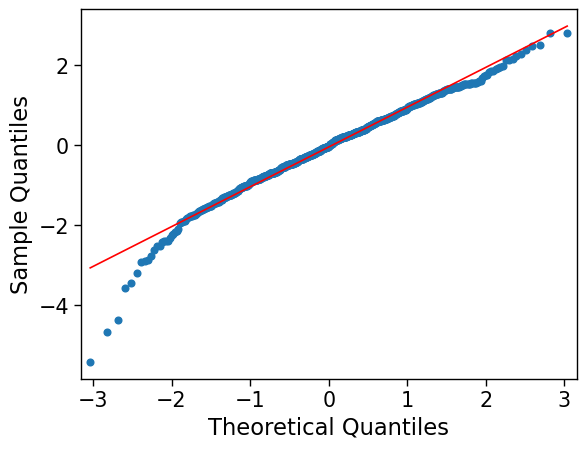

In [105]:
qqplot(get_resid_garch(result_student_11), line='r');

### SALVAR Modelos GARCH

In [106]:
modelToSave = arch_model(df['returns'], vol='GARCH', p=1, q=1, dist="StudentsT").fit(disp='off')
scaler_garch_to_save, scaled_cond_vol_to_save = scale_tf_cond_vol(modelToSave)
df['garch11_student'] = scaled_cond_vol_to_save

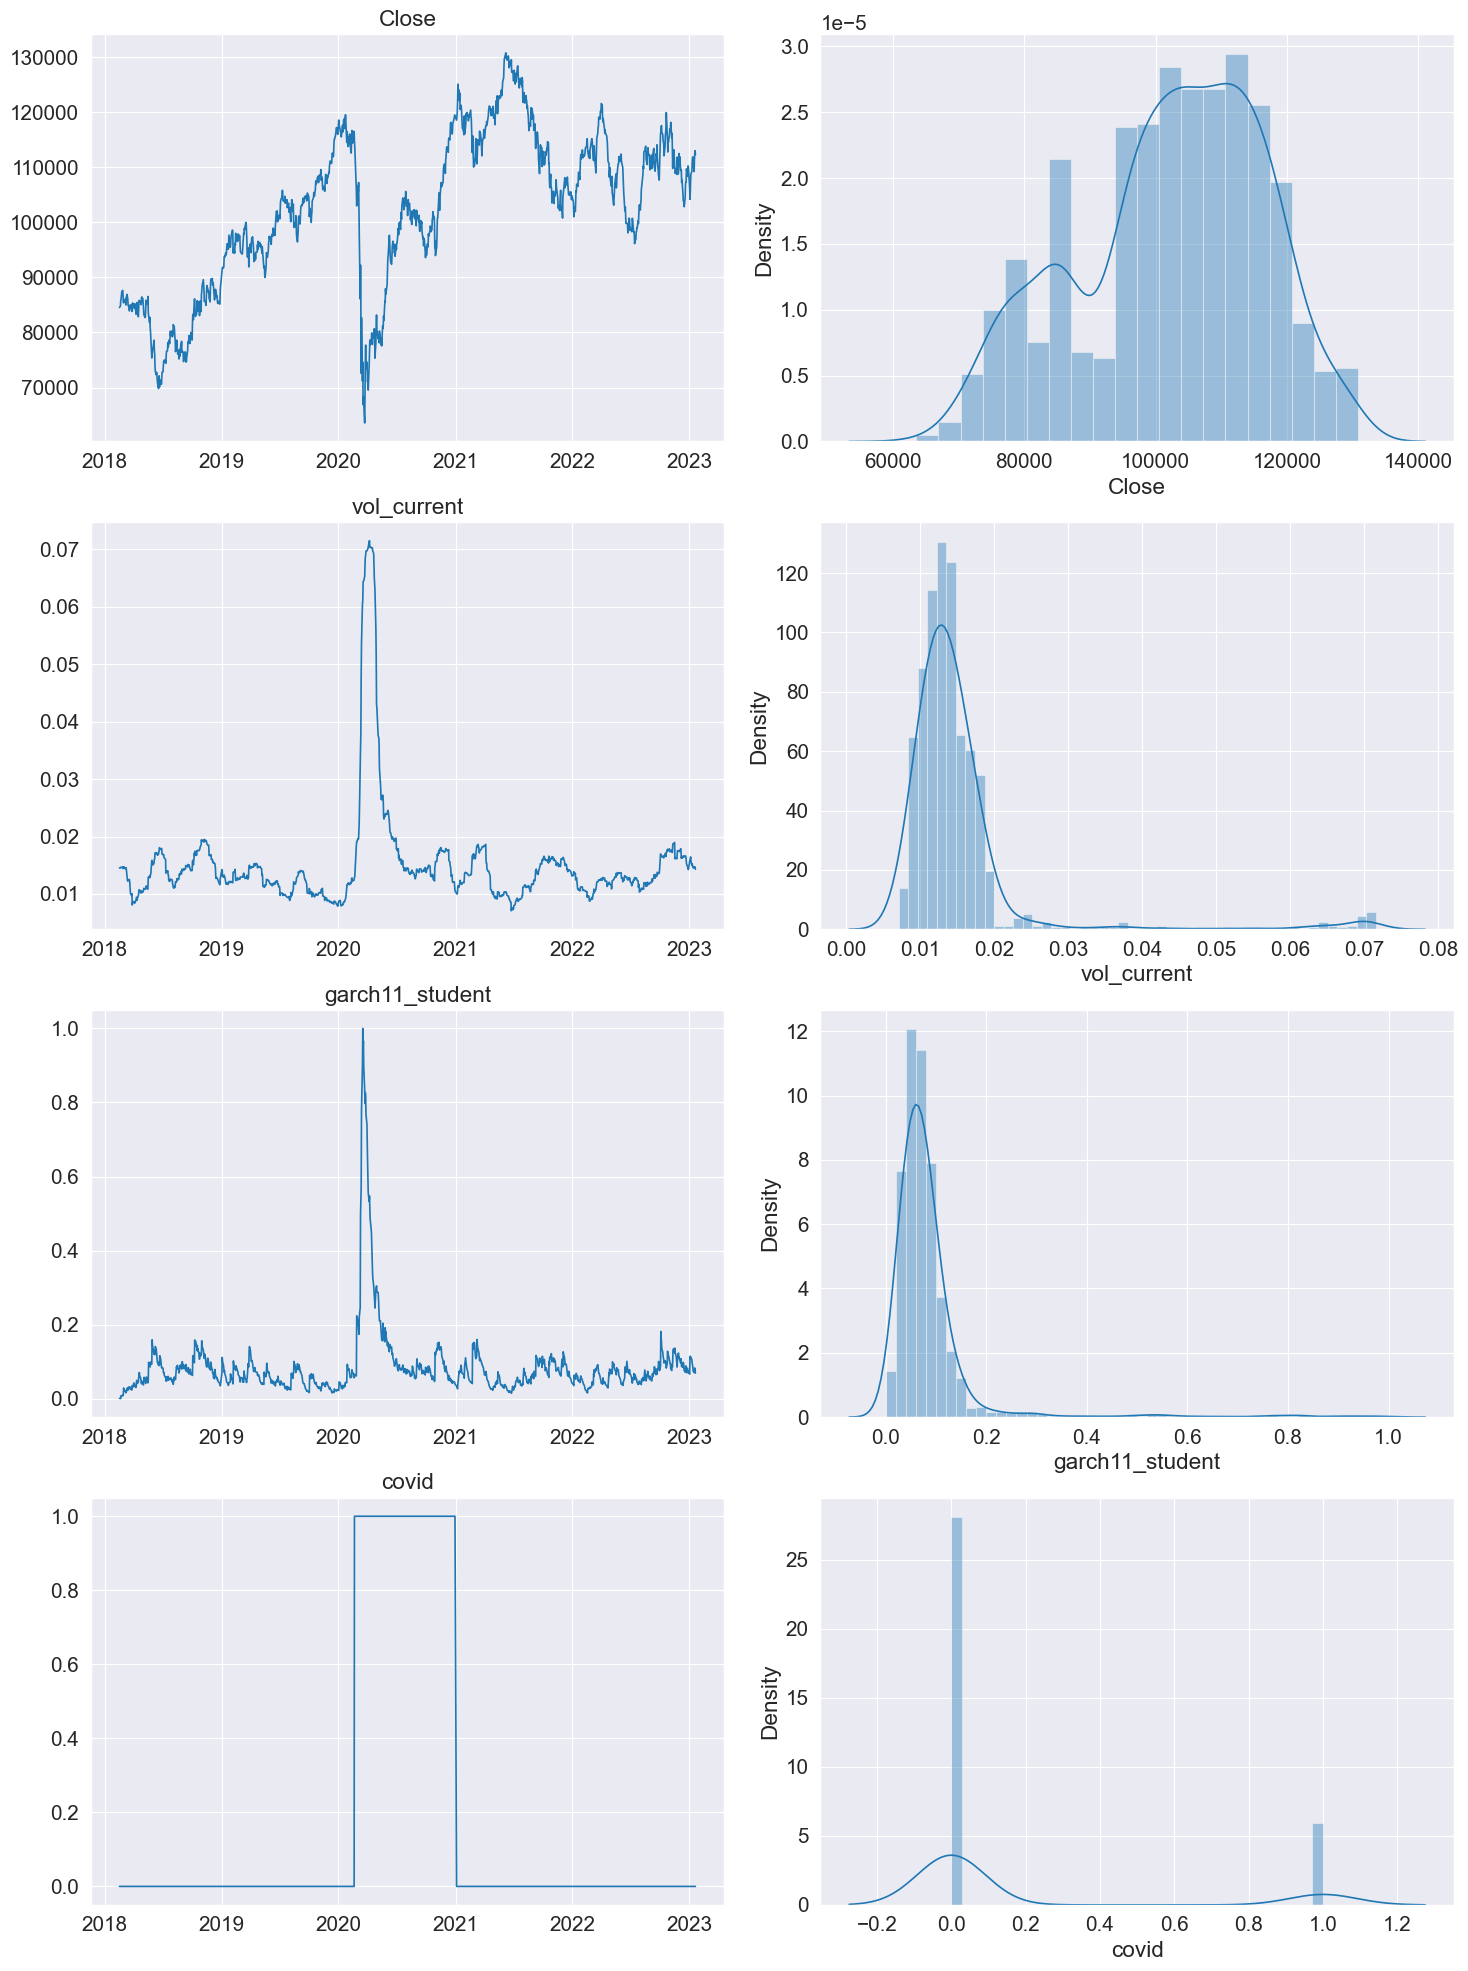

In [107]:
features = ['Close', 'vol_current', 'garch11_student', 'covid']
# PLOT EACH NUMERICAL COLUMN
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20))

    for i, c in enumerate(features):
        ax1, ax2 = axes[i][0], axes[i][1]
        ax1.plot(df[c])
        ax1.set_title(c)

        sns.distplot(df[c], ax=ax2)

    plt.tight_layout()
    # plt.savefig(os.path.join(directory_to_img, 'features.png'), 
    #             dpi=300, bbox_inches='tight')
    plt.show();

### REDES NEURAIS

In [108]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

In [109]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY)

In [110]:
def scale(scaler, y_series):
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [111]:
# Forecast RNN
def forecast(model, range_idx, n_past):
    location_index = df.vol_current.index.get_loc(range_idx[0])
    end_idx = range_idx[-1]
    start_idx = df.vol_current.iloc[location_index - n_past + 1:].index[0]
    mat_X, _ = windowed_dataset(df.vol_current[start_idx:end_idx], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [112]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

In [113]:
from keras import backend

def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))


In [114]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[n_past], activation='relu'),                         
    #  tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)
])
# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')


snn_2.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])
snn_2.summary()

snn_2_res = snn_2.fit(mat_X_train, mat_y_train, epochs=1000,
                      validation_split=0.2,
                      callbacks=[early_stopping_cb],
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)
snn_2_preds = forecast(snn_2, val_idx, n_past=n_past)
snn_2_preds_scaled = scale(scaler_vol, snn_2_preds)
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_2_preds_scaled,
         f"Simple LR Fully Connected NN, 30 units, {len(snn_2_res.epoch)}/1000 epochs, n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
12/12 [==============================] - 0s 1ms/step


,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894


In [115]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, input_shape=[n_past], activation='relu'),                         
    #  tf.keras.layers.Dense(50, activation='relu'),
    #  tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

snn_3.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe]
              )
snn_3.summary()
snn_3_res = snn_3.fit(mat_X_train, mat_y_train, epochs=1000,
                      validation_split=0.2,
                       callbacks=[early_stopping_cb],
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)
snn_3_preds = forecast(snn_3, val_idx, n_past)
snn_3_preds_scaled = scale(scaler_vol, snn_3_preds)
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_3_preds_scaled,
         f"Simple LR Fully Connected NN, 50 units, {len(snn_3_res.epoch)}/1000 epochs, n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1550      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________
12/12 [==============================] - 0s 1ms/step


,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487


In [116]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 60
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_4 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[n_past], activation='relu'),                         
    #  tf.keras.layers.Dense(50, activation='relu'),
    #  tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

snn_4.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe]
              )
snn_4.summary()
snn_4_res = snn_4.fit(mat_X_train, mat_y_train, epochs=1000,
                      validation_split=0.2,
                       callbacks=[early_stopping_cb],
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)
snn_4_preds = forecast(snn_4, val_idx, n_past)
snn_4_preds_scaled = scale(scaler_vol, snn_4_preds)
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_4_preds_scaled,
         f"Simple LR Fully Connected NN, 30 units, {len(snn_4_res.epoch)}/1000 epochs, n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                1830      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________
12/12 [==============================] - 0s 1ms/step


,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581


In [117]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 60
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_5 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, input_shape=[n_past], activation='relu'),                         
    #  tf.keras.layers.Dense(50, activation='relu'),
    #  tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

snn_5.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe]
              )
snn_5.summary()
snn_5_res = snn_5.fit(mat_X_train, mat_y_train, epochs=1000,
                      validation_split=0.2,
                       callbacks=[early_stopping_cb],
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)
snn_5_preds = forecast(snn_5, val_idx, n_past)
snn_5_preds_scaled = scale(scaler_vol, snn_5_preds)
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_5_preds_scaled,
         f"Simple LR Fully Connected NN, 50 units, {len(snn_5_res.epoch)}/1000 epochs, n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                3050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,101
Trainable params: 3,101
Non-trainable params: 0
_________________________________________________________________
12/12 [==============================] - 0s 907us/step


,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035


In [118]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_6 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[n_past], activation='relu'),                         
    #  tf.keras.layers.Dense(50, activation='relu'),
     tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

snn_6.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe]
              )
snn_6.summary()
snn_6_res = snn_6.fit(mat_X_train, mat_y_train, epochs=1000,
                      validation_split=0.2,
                      callbacks=[early_stopping_cb],
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)
snn_6_preds = forecast(snn_6, val_idx, n_past)
snn_6_preds_scaled = scale(scaler_vol, snn_6_preds)
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_6_preds_scaled,
         f"Simple LR Fully Connected NN, 30 units, Dropout (10%) {len(snn_5_res.epoch)}/1000 epochs, n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
12/12 [==============================] - 0s 907us/step


,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000518,0.742846,0.022763,0.326157


In [119]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_7 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, input_shape=[n_past], activation='relu'),                         
    #  tf.keras.layers.Dense(50, activation='relu'),
     tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

snn_7.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe]
              )
snn_7.summary()
snn_7_res = snn_7.fit(mat_X_train, mat_y_train, epochs=1000,
                      validation_split=0.2,
                      callbacks=[early_stopping_cb],
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)
snn_7_preds = forecast(snn_7, val_idx, n_past)
snn_7_preds_scaled = scale(scaler_vol, snn_7_preds)
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_7_preds_scaled,
         f"Simple LR Fully Connected NN, 50 units, Dropout (10%) {len(snn_5_res.epoch)}/1000 epochs, n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1550      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________
12/12 [==============================] - 0s 1ms/step


,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000518,0.742846,0.022763,0.326157
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000437,0.630741,0.020905,0.291224


In [120]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 60
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_8 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[n_past], activation='relu'),                         
    #  tf.keras.layers.Dense(50, activation='relu'),
     tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

snn_8.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe]
              )
snn_8.summary()
snn_8_res = snn_8.fit(mat_X_train, mat_y_train, epochs=1000,
                      validation_split=0.2,
                      callbacks=[early_stopping_cb],
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)
snn_8_preds = forecast(snn_8, val_idx, n_past)
snn_8_preds_scaled = scale(scaler_vol, snn_8_preds)
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_8_preds_scaled,
         f"Simple LR Fully Connected NN, 30 units, Dropout (10%) {len(snn_5_res.epoch)}/1000 epochs, n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                1830      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________
12/12 [==============================] - 0s 907us/step


,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000518,0.742846,0.022763,0.326157
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000437,0.630741,0.020905,0.291224
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000864,0.986822,0.029394,0.438549


In [121]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 60
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_9 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, input_shape=[n_past], activation='relu'),                         
    #  tf.keras.layers.Dense(50, activation='relu'),
     tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

snn_9.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe]
              )
snn_9.summary()
snn_9_res = snn_9.fit(mat_X_train, mat_y_train, epochs=1000,
                      validation_split=0.2,
                      callbacks=[early_stopping_cb],
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)
snn_9_preds = forecast(snn_9, val_idx, n_past)
snn_9_preds_scaled = scale(scaler_vol, snn_9_preds)
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_9_preds_scaled,
         f"Simple LR Fully Connected NN, 50 units, Dropout (10%) {len(snn_5_res.epoch)}/1000 epochs, n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                3050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,101
Trainable params: 3,101
Non-trainable params: 0
_________________________________________________________________
12/12 [==============================] - 0s 968us/step


,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000518,0.742846,0.022763,0.326157
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000437,0.630741,0.020905,0.291224
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000864,0.986822,0.029394,0.438549
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000560,0.379279,0.023654,0.280776


### LSTM


In [122]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from decimal import Decimal

In [123]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(30),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])
# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_1.summary()
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train, 
                        callbacks=[early_stopping_cb],
                        validation_split=0.2, 
                        shuffle=False,
                        batch_size=batch_size, 
                        epochs=1000)
lstm_1_preds = forecast(lstm_1, val_idx, n_past=n_past)
lstm_1_preds_scaled = scale(scaler_vol, lstm_1_preds)
log_perf(y_val_scaled, lstm_1_preds_scaled,
         f"LSTM 1 layer, 30 units, {len(lstm_1_res.epoch)}/1000 epochs, n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 3s 67ms/step - loss: 2.3782e-04 - rmspe: 0.0110 - val_loss: 3.8300e-05 - val_rmspe: 0.0051
Epoch 2/1000
10/10 [==============================] - 0s 12ms/step - loss: 1.7255e-04 - rmspe: 0.0067 - val_loss: 1.6719e-05 - val_rmspe: 0.0035
Epoch 3/1000
10/10 [========

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000518,0.742846,0.022763,0.326157
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000437,0.630741,0.020905,0.291224
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000864,0.986822,0.029394,0.438549
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000560,0.379279,0.023654,0.280776


In [124]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(50),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])
# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_2.summary()
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, 
                        callbacks=[early_stopping_cb],
                        validation_split=0.2, 
                        shuffle=False,
                        batch_size=batch_size, 
                        epochs=1000)
lstm_2_preds = forecast(lstm_2, val_idx, n_past=n_past)
lstm_2_preds_scaled = scale(scaler_vol, lstm_2_preds)
log_perf(y_val_scaled, lstm_2_preds_scaled,
         f"LSTM 1 layer, 50 units, {len(lstm_2_res.epoch)}/1000 epochs, n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 3s 71ms/step - loss: 1.7668e-04 - rmspe: 0.0081 - val_loss: 1.0805e-05 - val_rmspe: 0.0029
Epoch 2/1000
10/10 [==============================] - 0s 15ms/step - loss: 1.0121e-04 - rmspe: 0.0061 - val_loss: 1.7803e-05 - val_rmspe: 0.0034
Epoch 3/1000
10/10 [======

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000518,0.742846,0.022763,0.326157
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000437,0.630741,0.020905,0.291224
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000864,0.986822,0.029394,0.438549
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000560,0.379279,0.023654,0.280776


In [125]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 60
batch_size = 64
mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(30),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_3.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])
# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_3.summary()
lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train, 
                        callbacks=[early_stopping_cb],
                        validation_split=0.2, 
                        shuffle=False,
                        batch_size=batch_size, 
                        epochs=1000)
lstm_3_preds = forecast(lstm_3, val_idx, n_past=n_past)
lstm_3_preds_scaled = scale(scaler_vol, lstm_3_preds)
log_perf(y_val_scaled, lstm_3_preds_scaled,
         f"LSTM 1 layer, 30 units, {len(lstm_3_res.epoch)}/1000 epochs, n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 3s 73ms/step - loss: 1.9934e-04 - rmspe: 0.0101 - val_loss: 4.3839e-05 - val_rmspe: 0.0057
Epoch 2/1000
10/10 [==============================] - 0s 19ms/step - loss: 1.5701e-04 - rmspe: 0.0066 - val_loss: 1.4354e-05 - val_rmspe: 0.0033
Epoch 3/1000
10/10 [========

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000518,0.742846,0.022763,0.326157
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000437,0.630741,0.020905,0.291224
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000864,0.986822,0.029394,0.438549
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000560,0.379279,0.023654,0.280776


In [126]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 60
batch_size = 64
mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(50),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_4.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])
# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_4.summary()
lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, 
                        callbacks=[early_stopping_cb],
                        validation_split=0.2, 
                        shuffle=False,
                        batch_size=batch_size, 
                        epochs=1000)
lstm_4_preds = forecast(lstm_4, val_idx, n_past=n_past)
lstm_4_preds_scaled = scale(scaler_vol, lstm_4_preds)
log_perf(y_val_scaled, lstm_4_preds_scaled,
         f"LSTM 1 layer, 50 units, {len(lstm_4_res.epoch)}/1000 epochs, n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 3s 77ms/step - loss: 1.4853e-04 - rmspe: 0.0075 - val_loss: 1.4263e-05 - val_rmspe: 0.0031
Epoch 2/1000
10/10 [==============================] - 0s 26ms/step - loss: 9.0957e-05 - rmspe: 0.0060 - val_loss: 9.0013e-06 - val_rmspe: 0.0026
Epoch 3/1000
10/10 [======

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000518,0.742846,0.022763,0.326157
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000437,0.630741,0.020905,0.291224
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000864,0.986822,0.029394,0.438549
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000560,0.379279,0.023654,0.280776


In [127]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_5 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(30),
    tf.keras.layers.Dropout(0.1),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_5.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])
# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_5.summary()
lstm_5_res = lstm_5.fit(mat_X_train, mat_y_train, 
                        callbacks=[early_stopping_cb],
                        validation_split=0.2, 
                        shuffle=False,
                        batch_size=batch_size, 
                        epochs=1000)
lstm_5_preds = forecast(lstm_5, val_idx, n_past=n_past)
lstm_5_preds_scaled = scale(scaler_vol, lstm_5_preds)
log_perf(y_val_scaled, lstm_5_preds_scaled,
         f"LSTM 1 layer, 30 units, {len(lstm_5_res.epoch)}/1000 epochs, n_past={n_past}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 3s 67ms/step - loss: 2.1052e-04 - rmspe: 0.0101 - val_loss: 3.0537e-05 - val_rmspe: 0.0045
Epoch 2/1000
10/10 [=====================

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000518,0.742846,0.022763,0.326157
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000437,0.630741,0.020905,0.291224
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000864,0.986822,0.029394,0.438549
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000560,0.379279,0.023654,0.280776


In [128]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_6 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dropout(0.1),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_6.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])
# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_6.summary()
lstm_6_res = lstm_6.fit(mat_X_train, mat_y_train, 
                        callbacks=[early_stopping_cb],
                        validation_split=0.2, 
                        shuffle=False,
                        batch_size=batch_size, 
                        epochs=1000)
lstm_6_preds = forecast(lstm_6, val_idx, n_past=n_past)
lstm_6_preds_scaled = scale(scaler_vol, lstm_6_preds)
log_perf(y_val_scaled, lstm_6_preds_scaled,
         f"LSTM 1 layer, 50 units, Dropout(10%), {len(lstm_6_res.epoch)}/1000 epochs, n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 3s 76ms/step - loss: 2.3434e-04 - rmspe: 0.0101 - val_loss: 1.7554e-05 - val_rmspe: 0.0036
Epoch 2/1000
10/10 [===================

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000518,0.742846,0.022763,0.326157
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000437,0.630741,0.020905,0.291224
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000864,0.986822,0.029394,0.438549
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000560,0.379279,0.023654,0.280776


In [129]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 60
batch_size = 64
mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_7 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(30),
    tf.keras.layers.Dropout(0.1),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_7.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])
# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_7.summary()
lstm_7_res = lstm_7.fit(mat_X_train, mat_y_train, 
                        callbacks=[early_stopping_cb],
                        validation_split=0.2, 
                        shuffle=False,
                        batch_size=batch_size, 
                        epochs=1000)
lstm_7_preds = forecast(lstm_7, val_idx, n_past=n_past)
lstm_7_preds_scaled = scale(scaler_vol, lstm_7_preds)

log_perf(y_val_scaled, lstm_7_preds_scaled,
         f"LSTM 1 layer, 30 units, Dropout(10%), {len(lstm_7_res.epoch)}/1000 epochs, n_past={n_past}")

tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 60
batch_size = 64
mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_8 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dropout(0.1),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_8.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])
# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_8.summary()
lstm_8_res = lstm_8.fit(mat_X_train, mat_y_train, 
                        callbacks=[early_stopping_cb],
                        validation_split=0.2, 
                        shuffle=False,
                        batch_size=batch_size, 
                        epochs=1000)
lstm_8_preds = forecast(lstm_8, val_idx, n_past=n_past)
lstm_8_preds_scaled = scale(scaler_vol, lstm_8_preds)
log_perf(y_val_scaled, lstm_8_preds_scaled,
         f"LSTM 1 layer, 50 units, Dropout(10%), {len(lstm_8_res.epoch)}/1000 epochs, n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 3s 73ms/step - loss: 2.0611e-04 - rmspe: 0.0100 - val_loss: 3.0308e-05 - val_rmspe: 0.0045
Epoch 2/1000
10/10 [=====================

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000518,0.742846,0.022763,0.326157
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000437,0.630741,0.020905,0.291224
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000864,0.986822,0.029394,0.438549
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000560,0.379279,0.023654,0.280776


In [130]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_9 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_9.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])


# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_9.summary()
lstm_9_res = lstm_9.fit(mat_X_train, mat_y_train, 
                        callbacks=[early_stopping_cb],
                        validation_split=0.2, 
                        shuffle=False,
                        batch_size=batch_size, 
                        epochs=1000)
lstm_9_preds = forecast(lstm_9, val_idx, n_past=n_past)
lstm_9_preds_scaled = scale(scaler_vol, lstm_9_preds)
log_perf(y_val_scaled, lstm_9_preds_scaled, 
         f"2 layers Bidirect LSTM (50/30 units), {len(lstm_9_res.epoch)}/1000 epochs,  n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 100)        20800     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60)               31440     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 52,301
Trainable params: 52,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] 

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000518,0.742846,0.022763,0.326157
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000437,0.630741,0.020905,0.291224
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000864,0.986822,0.029394,0.438549
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000560,0.379279,0.023654,0.280776


In [131]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 60
batch_size = 64
mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_10 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_10.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])


# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_10.summary()
lstm_10_res = lstm_10.fit(mat_X_train, mat_y_train, 
                        callbacks=[early_stopping_cb],
                        validation_split=0.2, 
                        shuffle=False,
                        batch_size=batch_size, 
                        epochs=1000)
lstm_10_preds = forecast(lstm_10, val_idx, n_past=n_past)
lstm_10_preds_scaled = scale(scaler_vol, lstm_10_preds)
log_perf(y_val_scaled, lstm_10_preds_scaled, 
         f"2 layers Bidirect LSTM (50/30 units), {len(lstm_10_res.epoch)}/1000 epochs, n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 100)        20800     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60)               31440     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 52,301
Trainable params: 52,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] 

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000518,0.742846,0.022763,0.326157
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000437,0.630741,0.020905,0.291224
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000864,0.986822,0.029394,0.438549
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000560,0.379279,0.023654,0.280776


In [132]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_11 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30)),
    tf.keras.layers.Dropout(0.1),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_11.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])


# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_11.summary()
lstm_11_res = lstm_11.fit(mat_X_train, mat_y_train, 
                        callbacks=[early_stopping_cb],
                        validation_split=0.2, 
                        shuffle=False,
                        batch_size=batch_size, 
                        epochs=1000)
lstm_11_preds = forecast(lstm_11, val_idx, n_past=n_past)
lstm_11_preds_scaled = scale(scaler_vol, lstm_11_preds)
log_perf(y_val_scaled, lstm_11_preds_scaled, 
         f"2 layers Bidirect LSTM (50/30 units), {len(lstm_11_res.epoch)}, Dropout (10%), n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 100)        20800     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60)               31440     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 52,301
Trainable params: 52,301
Non-traina

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000518,0.742846,0.022763,0.326157
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000437,0.630741,0.020905,0.291224
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000864,0.986822,0.029394,0.438549
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000560,0.379279,0.023654,0.280776


In [133]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 60
batch_size = 64
mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_12 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30)),
    tf.keras.layers.Dropout(0.1),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_12.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])


# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_12.summary()
lstm_12_res = lstm_12.fit(mat_X_train, mat_y_train, 
                        callbacks=[early_stopping_cb],
                        validation_split=0.2, 
                        shuffle=False,
                        batch_size=batch_size, 
                        epochs=1000)
lstm_12_preds = forecast(lstm_12, val_idx, n_past=n_past)
lstm_12_preds_scaled = scale(scaler_vol, lstm_12_preds)
log_perf(y_val_scaled, lstm_12_preds_scaled, 
         f"2 layers Bidirect LSTM (50/30 units), {len(lstm_12_res.epoch)},Droupout(10%), n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 100)        20800     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60)               31440     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 52,301
Trainable params: 52,301
Non-traina

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000518,0.742846,0.022763,0.326157
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000437,0.630741,0.020905,0.291224
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000864,0.986822,0.029394,0.438549
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000560,0.379279,0.023654,0.280776


In [134]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_14 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30)),
    tf.keras.layers.Dropout(0.2),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_14.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])


# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_14.summary()
lstm_14_res = lstm_14.fit(mat_X_train, mat_y_train, 
                        callbacks=[early_stopping_cb],
                        validation_split=0.2, 
                        shuffle=False,
                        batch_size=batch_size, 
                        epochs=1000)
lstm_14_preds = forecast(lstm_14, val_idx, n_past=n_past)
lstm_14_preds_scaled = scale(scaler_vol, lstm_14_preds)
log_perf(y_val_scaled, lstm_14_preds_scaled, 
         f"2 layers Bidirect LSTM (50/30 units), {len(lstm_14_res.epoch)},Droupout(10%), n_past={n_past}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 100)        20800     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60)               31440     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 52,301
Trainable params: 52,301
Non-traina

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001125,0.508638,0.033547,0.337772
"GARCH(1,1) - Student",0.001019,0.492070,0.031925,0.322151
"Simple LR Fully Connected NN, 30 units, 135/1000 epochs, n_past=30",0.000589,0.480030,0.024276,0.294894
"Simple LR Fully Connected NN, 50 units, 84/1000 epochs, n_past=30",0.000623,0.427644,0.024953,0.306487
"Simple LR Fully Connected NN, 30 units, 92/1000 epochs, n_past=60",0.000563,0.423145,0.023724,0.287581
"Simple LR Fully Connected NN, 50 units, 335/1000 epochs, n_past=60",0.000546,0.758493,0.023362,0.333035
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000518,0.742846,0.022763,0.326157
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=30",0.000437,0.630741,0.020905,0.291224
"Simple LR Fully Connected NN, 30 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000864,0.986822,0.029394,0.438549
"Simple LR Fully Connected NN, 50 units, Dropout (10%) 335/1000 epochs, n_past=60",0.000560,0.379279,0.023654,0.280776
